# 서울시 요식업 평균 매출 예측 모델
서울시 요식업 매출 데이터 분석 및 예측 모델 구축

## 1. 데이터 로딩과 전처리

### 1.1 라이브러리 임포트

In [146]:
# 데이터 분석 및 시각화 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 머신러닝 모델링 라이브러리
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# 결과 저장 디렉토리 생성
Path('plots').mkdir(exist_ok=True)
Path('models').mkdir(exist_ok=True)

# 랜덤 시드 설정
RANDOM_STATE = 42

### 1.2 데이터 로드

In [147]:
# 데이터셋 로드
sales_df = pd.read_csv("data/서울시 상권분석서비스(추정매출-상권).csv", encoding="cp949")
work_df = pd.read_csv("data/서울시 상권분석서비스(직장인구-상권).csv", encoding="cp949")
street_df = pd.read_csv("data/서울시 상권분석서비스(길단위인구-상권).csv", encoding="cp949")

### 1.3 데이터 기본 정보 확인

In [148]:
# 데이터셋 크기 확인
print("\n=== 데이터셋 기본 정보 ===")
print(f"매출 데이터: {sales_df.shape[0]:,}행, {sales_df.shape[1]}열")
print(f"직장인구 데이터: {work_df.shape[0]:,}행, {work_df.shape[1]}열")
print(f"유동인구 데이터: {street_df.shape[0]:,}행, {street_df.shape[1]}열")


=== 데이터셋 기본 정보 ===
매출 데이터: 87,179행, 55열
직장인구 데이터: 6,549행, 26열
유동인구 데이터: 6,595행, 27열


### 1.4 매출 데이터 확인

In [149]:
# 데이터 샘플 확인
print("\n=== 매출 데이터 샘플 ===")
display(sales_df.head(3))

# 데이터 정보 확인
print("\n=== 매출 데이터 정보 ===")
display(sales_df.info())

# 서비스 업종 코드명 확인
print("\n=== 서비스 업종 코드명 목록 ===")
print(sales_df["서비스_업종_코드_명"].unique())

# 컬럼 목록 확인
print("\n=== 매출 데이터 컬럼 목록 ===")
print(sales_df.columns.tolist())


=== 매출 데이터 샘플 ===


,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,U,관광특구,3001491,이태원 관광특구,CS100001,한식음식점,1.185751e+10,254192,6.640829e+09,...,69016,38472,129419,109336,1277,73116,86124,33511,28074,16652
1,20241,U,관광특구,3001491,이태원 관광특구,CS100002,중식음식점,1.911647e+09,46140,1.259317e+09,...,18085,4918,21479,21646,151,14443,15206,5918,4892,2514
2,20241,U,관광특구,3001491,이태원 관광특구,CS100003,일식음식점,7.273213e+08,10811,4.611840e+08,...,3596,2734,4855,4682,52,2911,3636,1345,1222,371



=== 매출 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87179 entries, 0 to 87178
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        87179 non-null  int64  
 1   상권_구분_코드         87179 non-null  object 
 2   상권_구분_코드_명       87179 non-null  object 
 3   상권_코드            87179 non-null  int64  
 4   상권_코드_명          87179 non-null  object 
 5   서비스_업종_코드        87179 non-null  object 
 6   서비스_업종_코드_명      87179 non-null  object 
 7   당월_매출_금액         87179 non-null  float64
 8   당월_매출_건수         87179 non-null  int64  
 9   주중_매출_금액         87179 non-null  float64
 10  주말_매출_금액         87179 non-null  float64
 11  월요일_매출_금액        87179 non-null  float64
 12  화요일_매출_금액        87179 non-null  float64
 13  수요일_매출_금액        87179 non-null  float64
 14  목요일_매출_금액        87179 non-null  float64
 15  금요일_매출_금액        87179 non-null  float64
 16  토요일_매출_금액        87179 non-null  float6

None


=== 서비스 업종 코드명 목록 ===
['한식음식점' '중식음식점' '일식음식점' '양식음식점' '제과점' '패스트푸드점' '치킨전문점' '분식전문점' '호프-간이주점'
 '커피-음료' '일반의원' '치과의원' '당구장' '스포츠클럽' '미용실' '네일숍' '피부관리실' '세탁소' '노래방'
 '슈퍼마켓' '편의점' '반찬가게' '일반의류' '신발' '가방' '안경' '시계및귀금속' '의약품' '서적' '화장품'
 '운동/경기용품' '섬유제품' '화초' '가구' '조명용품' '전자상거래업' '외국어학원' '예술학원' '스포츠 강습' '한의원'
 '골프연습장' '가전제품수리' '부동산중개업' '여관' '핸드폰' '미곡판매' '육류판매' '수산물판매' '청과상' '의료기기'
 '문구' '애완동물' '가전제품' '철물점' '인테리어' '일반교습학원' 'PC방' '컴퓨터및주변장치판매' '자동차수리' '완구'
 '자전거 및 기타운송장비' '자동차미용']

=== 매출 데이터 컬럼 목록 ===
['기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '당월_매출_금액', '당월_매출_건수', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건

### 1.5 결측치 및 요식업 코드 확인

In [150]:
# 결측치 확인
print("\n=== 결측치 확인 ===")
missing_sales = sales_df.isnull().sum()
missing_sales = missing_sales[missing_sales > 0]
if len(missing_sales) > 0:
    print("매출 데이터 결측치:")
    print(missing_sales)
else:
    print("매출 데이터에 결측치가 없습니다.")

# 요식업(CS1) 코드 분포 확인
print("\n=== 요식업 서비스 코드 분포 ===")
cs1_codes_count = sales_df["서비스_업종_코드"].str.startswith("CS1").value_counts()
print(f"요식업(CS1) 서비스 코드 수: {cs1_codes_count.get(True, 0):,}/{len(sales_df):,}")


=== 결측치 확인 ===
매출 데이터에 결측치가 없습니다.

=== 요식업 서비스 코드 분포 ===
요식업(CS1) 서비스 코드 수: 27,095/87,179


### 1.6 요식업 데이터 필터링

In [151]:
# 요식업(CS1) 데이터만 추출하기
restaurant_sales = sales_df[sales_df["서비스_업종_코드"].str.startswith("CS1")]
print(f"\n요식업(CS1) 데이터 추출: {len(restaurant_sales):,}행")

# 추출된 요식업 데이터 정보 확인
print("\n=== 요식업 데이터 정보 ===")
display(restaurant_sales.info())

# 업종 분포 확인
if '서비스_업종_코드_명' in restaurant_sales.columns:
    print("\n=== 요식업 유형 분포 ===")
    display(restaurant_sales['서비스_업종_코드_명'].value_counts())


요식업(CS1) 데이터 추출: 27,095행

=== 요식업 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
Index: 27095 entries, 0 to 87165
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년분기_코드        27095 non-null  int64  
 1   상권_구분_코드         27095 non-null  object 
 2   상권_구분_코드_명       27095 non-null  object 
 3   상권_코드            27095 non-null  int64  
 4   상권_코드_명          27095 non-null  object 
 5   서비스_업종_코드        27095 non-null  object 
 6   서비스_업종_코드_명      27095 non-null  object 
 7   당월_매출_금액         27095 non-null  float64
 8   당월_매출_건수         27095 non-null  int64  
 9   주중_매출_금액         27095 non-null  float64
 10  주말_매출_금액         27095 non-null  float64
 11  월요일_매출_금액        27095 non-null  float64
 12  화요일_매출_금액        27095 non-null  float64
 13  수요일_매출_금액        27095 non-null  float64
 14  목요일_매출_금액        27095 non-null  float64
 15  금요일_매출_금액        27095 non-null  float64
 16  토요일_매출_금액        

None


=== 요식업 유형 분포 ===


서비스_업종_코드_명
한식음식점      5645
커피-음료      4348
호프-간이주점    3641
분식전문점      3224
치킨전문점      2196
중식음식점      1839
제과점        1719
패스트푸드점     1718
일식음식점      1396
양식음식점      1369
Name: count, dtype: int64

### 1.7 상권별 평균 매출 계산

In [152]:
# 상권별, 분기별 평균매출 계산
grouped_sales = restaurant_sales.groupby(["상권_코드_명", "기준_년분기_코드"])[["당월_매출_금액"]].mean().reset_index()
grouped_sales.rename(columns={"당월_매출_금액": "평균매출"}, inplace=True)

# 상권 구분 코드 추출 (상권별로 고유한 값)
commercial_type_codes = sales_df[["상권_코드_명", "상권_구분_코드_명"]].drop_duplicates()

# 평균매출 데이터에 상권 구분 코드 병합
grouped_sales = pd.merge(grouped_sales, commercial_type_codes, on="상권_코드_명", how="left")

# 평균매출 통계 확인
print("\n=== 평균매출 기본 통계량 ===")
print(grouped_sales["평균매출"].describe())


=== 평균매출 기본 통계량 ===
count    5.915000e+03
mean     6.709910e+08
std      1.154353e+09
min      1.424950e+05
25%      1.727753e+08
50%      3.506407e+08
75%      6.727847e+08
max      1.964679e+10
Name: 평균매출, dtype: float64


### 1.8 매출 분포 시각화

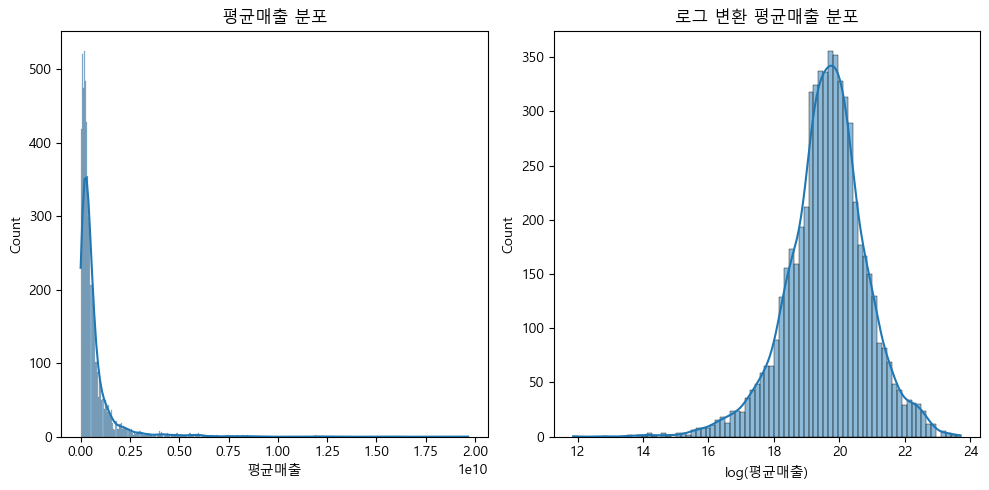

In [153]:
# 평균매출 분포 시각화
plt.figure(figsize=(10, 5))

# 원본 매출 분포
plt.subplot(1, 2, 1)
sns.histplot(grouped_sales["평균매출"], kde=True)
plt.title("평균매출 분포")
plt.xlabel("평균매출")

# 로그 변환 매출 분포 (0값 처리를 위해 log1p 변환 적용)
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(grouped_sales["평균매출"]), kde=True)
plt.title("로그 변환 평균매출 분포")
plt.xlabel("log(평균매출)")

plt.tight_layout()
plt.savefig('plots/sales_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.9 데이터 병합

In [154]:
# 병합 전 유동인구 데이터 확인
print("\n=== 유동인구(길단위) 데이터 샘플 ===")
display(street_df.head(3))

# 유동인구 데이터 정보 출력
print("\n=== 유동인구 데이터 정보 ===")
display(street_df.info())

# 병합 전 직장인구 데이터 확인
print("\n=== 직장인구 데이터 샘플 ===")
display(work_df.head(3))

# 직장인구 데이터 정보 출력
print("\n=== 직장인구 데이터 정보 ===")
display(work_df.info())

# 매출, 유동인구, 직장인구 데이터 병합
# 먼저 매출데이터(grouped_sales)와 유동인구 데이터(street_df) 병합
restaurant_data = pd.merge(grouped_sales, street_df, on=["상권_코드_명", "기준_년분기_코드"], how="left")

# 그 다음 직장인구 데이터(work_df) 병합
restaurant_data = pd.merge(restaurant_data, work_df, on=["상권_코드_명", "기준_년분기_코드"], how="left")

# 병합 결과 확인
print("\n=== 병합 결과 확인 ===")
print(f"원본 평균매출 데이터: {grouped_sales.shape[0]:,}행, {grouped_sales.shape[1]:,}열")
print(f"병합 후 데이터: {restaurant_data.shape[0]:,}행, {restaurant_data.shape[1]:,}열")

# 결측치 확인
missing_after_merge = restaurant_data.isnull().sum().sum()
missing_percent = (missing_after_merge / (restaurant_data.shape[0] * restaurant_data.shape[1])) * 100
print(f"병합 후 총 결측치: {missing_after_merge:,}개 ({missing_percent:.2f}%)")


=== 유동인구(길단위) 데이터 샘플 ===


,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,...,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_24_유동인구_수,월요일_유동인구_수,화요일_유동인구_수,수요일_유동인구_수,목요일_유동인구_수,금요일_유동인구_수,토요일_유동인구_수,일요일_유동인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,2155176,1100997,1054179,140314,532219,...,320185,435781,276720,284230,272781,286789,286045,318414,368486,338431
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,6889856,3343470,3546388,335824,1194547,...,1706632,1327800,343472,1040403,1133875,1202348,1130314,1103850,706014,573054
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,3384560,1595828,1788732,188119,645950,...,524693,620807,401942,504854,524755,553766,540100,497858,381895,381333



=== 유동인구 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6595 entries, 0 to 6594
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   기준_년분기_코드         6595 non-null   int64 
 1   상권_구분_코드          6595 non-null   object
 2   상권_구분_코드_명        6595 non-null   object
 3   상권_코드             6595 non-null   int64 
 4   상권_코드_명           6595 non-null   object
 5   총_유동인구_수          6595 non-null   int64 
 6   남성_유동인구_수         6595 non-null   int64 
 7   여성_유동인구_수         6595 non-null   int64 
 8   연령대_10_유동인구_수     6595 non-null   int64 
 9   연령대_20_유동인구_수     6595 non-null   int64 
 10  연령대_30_유동인구_수     6595 non-null   int64 
 11  연령대_40_유동인구_수     6595 non-null   int64 
 12  연령대_50_유동인구_수     6595 non-null   int64 
 13  연령대_60_이상_유동인구_수  6595 non-null   int64 
 14  시간대_00_06_유동인구_수  6595 non-null   int64 
 15  시간대_06_11_유동인구_수  6595 non-null   int64 
 16  시간대_11_14_유동인구_수  6595 non-null   int64

None


=== 직장인구 데이터 샘플 ===


,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20241,U,관광특구,3001491,이태원 관광특구,28395,15935,12460,8,6830,...,4986,4313,3583,842,0,4627,4869,2052,722,190
1,20241,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,214604,123445,91159,396,43270,...,38123,36717,25448,6374,309,26574,33802,18817,8660,2997
2,20241,U,관광특구,3001493,동대문패션타운 관광특구,33474,16833,16641,273,9661,...,4972,3883,2050,1183,164,5025,3641,2930,3328,1553



=== 직장인구 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6549 entries, 0 to 6548
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   기준_년분기_코드            6549 non-null   int64 
 1   상권_구분_코드             6549 non-null   object
 2   상권_구분_코드_명           6549 non-null   object
 3   상권_코드                6549 non-null   int64 
 4   상권_코드_명              6549 non-null   object
 5   총_직장_인구_수            6549 non-null   int64 
 6   남성_직장_인구_수           6549 non-null   int64 
 7   여성_직장_인구_수           6549 non-null   int64 
 8   연령대_10_직장_인구_수       6549 non-null   int64 
 9   연령대_20_직장_인구_수       6549 non-null   int64 
 10  연령대_30_직장_인구_수       6549 non-null   int64 
 11  연령대_40_직장_인구_수       6549 non-null   int64 
 12  연령대_50_직장_인구_수       6549 non-null   int64 
 13  연령대_60_이상_직장_인구_수    6549 non-null   int64 
 14  남성연령대_10_직장_인구_수     6549 non-null   int64 
 15  남성연령대_20_직장_인구_수     6549 non-null

None


=== 병합 결과 확인 ===
원본 평균매출 데이터: 5,915행, 4열
병합 후 데이터: 5,915행, 53열
병합 후 총 결측치: 653개 (0.21%)


### 1.10 병합 결과 확인

In [155]:
# 병합 결과 샘플 출력
print("\n=== 병합 결과 샘플 ===")
sample_cols = ['상권_코드_명', '기준_년분기_코드', '상권_구분_코드_명', '평균매출']
# 유동인구, 직장인구 컬럼이 있으면 출력 컬럼에 추가
if '총_유동인구_수' in restaurant_data.columns:
    sample_cols.append('총_유동인구_수')
if '총_직장_인구_수' in restaurant_data.columns:
    sample_cols.append('총_직장_인구_수')
display(restaurant_data[sample_cols].head(3))

# 결측치가 있는 행 확인
missing_rows = restaurant_data[restaurant_data.isnull().any(axis=1)]
print("\n=== 결측치가 있는 행 (앞부분 2개) ===")
display(missing_rows.head(2))

print("\n=== 결측치가 있는 행 (뒷부분 2개) ===")
display(missing_rows.tail(2))


=== 병합 결과 샘플 ===


,상권_코드_명,기준_년분기_코드,상권_구분_코드_명,평균매출,총_유동인구_수,총_직장_인구_수
0,4.19민주묘지역 2번,20241,골목상권,579173781.5,1021175.0,164.0
1,4.19민주묘지역 2번,20242,골목상권,647617846.2,1065757.0,164.0
2,4.19민주묘지역 2번,20243,골목상권,578556573.8,981924.0,164.0



=== 결측치가 있는 행 (앞부분 2개) ===


,상권_코드_명,기준_년분기_코드,평균매출,상권_구분_코드_명_x,상권_구분_코드_x,상권_구분_코드_명_y,상권_코드_x,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
179,강남시장(강남구 강남시장),20241,2.458933e+09,전통시장,R,전통시장,3130302.0,53239.0,25500.0,27738.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,강남시장(강남구 강남시장),20242,2.126333e+09,전통시장,R,전통시장,3130302.0,49086.0,23714.0,25372.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== 결측치가 있는 행 (뒷부분 2개) ===


,상권_코드_명,기준_년분기_코드,평균매출,상권_구분_코드_명_x,상권_구분_코드_x,상권_구분_코드_명_y,상권_코드_x,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
5463,태능엔터피아(태릉시장),20243,108413812.0,전통시장,R,전통시장,3130108.0,45403.0,22982.0,22421.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5579,한국교통안전공단 강남자동차검사소,20243,11714229.0,골목상권,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,6.0,6.0,0.0,0.0,3.0,3.0,4.0,3.0


### 1.11 결측치 처리

In [156]:
# 결측치 처리
# 수치형 컬럼은 중앙값으로 대체 (이상치에 덜 민감)
numeric_cols = restaurant_data.select_dtypes(include=['number']).columns
for col in numeric_cols:
    if restaurant_data[col].isnull().any():
        restaurant_data[col] = restaurant_data[col].fillna(restaurant_data[col].median())

# 문자열 컬럼은 최빈값으로 대체
object_cols = restaurant_data.select_dtypes(include=['object']).columns
for col in object_cols:
    if restaurant_data[col].isnull().any():
        # 최빈값이 없는 경우 '알수없음'으로 대체
        mode_value = restaurant_data[col].mode().iloc[0] if not restaurant_data[col].mode().empty else "알수없음"
        restaurant_data[col] = restaurant_data[col].fillna(mode_value)

# 결측치 처리 후 확인
missing_rows = restaurant_data[restaurant_data.isnull().any(axis=1)]
print("\n=== 결측치 처리 후 확인 ===")
print(f"결측치가 있는 행 수: {len(missing_rows)}")

# 데이터 정보 확인
print("\n=== 결측치 처리 후 데이터 정보 ===")
display(restaurant_data.info())

# 컬럼 목록 확인
print("\n=== 결측치 처리 후 컬럼 목록 ===")
print(restaurant_data.columns.tolist())


=== 결측치 처리 후 확인 ===
결측치가 있는 행 수: 0

=== 결측치 처리 후 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5915 entries, 0 to 5914
Data columns (total 53 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   상권_코드_명              5915 non-null   object 
 1   기준_년분기_코드            5915 non-null   int64  
 2   평균매출                 5915 non-null   float64
 3   상권_구분_코드_명_x         5915 non-null   object 
 4   상권_구분_코드_x           5915 non-null   object 
 5   상권_구분_코드_명_y         5915 non-null   object 
 6   상권_코드_x              5915 non-null   float64
 7   총_유동인구_수             5915 non-null   float64
 8   남성_유동인구_수            5915 non-null   float64
 9   여성_유동인구_수            5915 non-null   float64
 10  연령대_10_유동인구_수        5915 non-null   float64
 11  연령대_20_유동인구_수        5915 non-null   float64
 12  연령대_30_유동인구_수        5915 non-null   float64
 13  연령대_40_유동인구_수        5915 non-null   float64
 14  연령대_50_유동인구_수        5915 n

None


=== 결측치 처리 후 컬럼 목록 ===
['상권_코드_명', '기준_년분기_코드', '평균매출', '상권_구분_코드_명_x', '상권_구분_코드_x', '상권_구분_코드_명_y', '상권_코드_x', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수', '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수', '시간대_00_06_유동인구_수', '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수', '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수', '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수', '상권_구분_코드_y', '상권_구분_코드_명', '상권_코드_y', '총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수', '연령대_10_직장_인구_수', '연령대_20_직장_인구_수', '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수', '연령대_60_이상_직장_인구_수', '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수', '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수', '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수', '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수']


## 2. 특성 엔지니어링

### 2.1 특성 후보 정의

In [157]:
# 모델링에 사용할 수 있는 모든 특성 후보 정의
# 1) 원본 수치형 특성
numeric_feature_candidates = [
    # 유동인구 관련 특성
    "총_유동인구_수", "남성_유동인구_수", "여성_유동인구_수", 
    "연령대_10_유동인구_수", "연령대_20_유동인구_수", "연령대_30_유동인구_수", 
    "연령대_40_유동인구_수", "연령대_50_유동인구_수", "연령대_60_이상_유동인구_수",
    
    # 직장인구 관련 특성
    "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수",
    "연령대_10_직장_인구_수", "연령대_20_직장_인구_수", "연령대_30_직장_인구_수", 
    "연령대_40_직장_인구_수", "연령대_50_직장_인구_수", "연령대_60_이상_직장_인구_수"
]

# 2) 범주형 특성 후보
categorical_feature_candidates = ["상권_구분_코드_명", "기준_년분기_코드"]

# 데이터프레임에서 필요한 열만 선택하여 특성 엔지니어링용 데이터셋 생성
feature_engineering_df = restaurant_data.copy()

### 2.2 연령대별 인구 통합 특성 생성

In [158]:
# 연령대 그룹핑 (초년(10-20대)/중년(30-40대)/노년(50대 이상))
# 유동인구 연령대별 통합
feature_engineering_df["초년_유동인구_수"] = feature_engineering_df["연령대_10_유동인구_수"] + feature_engineering_df["연령대_20_유동인구_수"]
feature_engineering_df["중년_유동인구_수"] = feature_engineering_df["연령대_30_유동인구_수"] + feature_engineering_df["연령대_40_유동인구_수"]
feature_engineering_df["노년_유동인구_수"] = feature_engineering_df["연령대_50_유동인구_수"] + feature_engineering_df["연령대_60_이상_유동인구_수"]

# 직장인구 연령대별 통합
feature_engineering_df["초년_직장_인구_수"] = feature_engineering_df["연령대_10_직장_인구_수"] + feature_engineering_df["연령대_20_직장_인구_수"]
feature_engineering_df["중년_직장_인구_수"] = feature_engineering_df["연령대_30_직장_인구_수"] + feature_engineering_df["연령대_40_직장_인구_수"]
feature_engineering_df["노년_직장_인구_수"] = feature_engineering_df["연령대_50_직장_인구_수"] + feature_engineering_df["연령대_60_이상_직장_인구_수"]

# 생성된 연령대 특성을 후보 목록에 추가
age_features = ["초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수", 
               "초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수"]
numeric_feature_candidates.extend(age_features)

### 2.3 성별 인구 비율 특성 생성

In [159]:
# 성별 인구 비율 계산 (총 인구 대비 각 성별 비율)
feature_engineering_df['남성_유동인구_비율'] = feature_engineering_df['남성_유동인구_수'] / feature_engineering_df['총_유동인구_수']
feature_engineering_df['여성_유동인구_비율'] = feature_engineering_df['여성_유동인구_수'] / feature_engineering_df['총_유동인구_수']
feature_engineering_df['남성_직장인구_비율'] = feature_engineering_df['남성_직장_인구_수'] / feature_engineering_df['총_직장_인구_수']
feature_engineering_df['여성_직장인구_비율'] = feature_engineering_df['여성_직장_인구_수'] / feature_engineering_df['총_직장_인구_수']

# 0으로 나누는 경우(분모가 0인 경우) 처리
for col in ['남성_유동인구_비율', '여성_유동인구_비율', '남성_직장인구_비율', '여성_직장인구_비율']:
    feature_engineering_df[col] = feature_engineering_df[col].fillna(0)

# 생성된 성별 비율 특성을 후보 목록에 추가
gender_ratio_features = ['남성_유동인구_비율', '여성_유동인구_비율', '남성_직장인구_비율', '여성_직장인구_비율']
numeric_feature_candidates.extend(gender_ratio_features)

### 2.4 복합 특성 생성

In [160]:
# 복합 특성 생성
# 1. 총 인구 수 (유동+직장) 계산
feature_engineering_df['총_인구_수'] = feature_engineering_df['총_유동인구_수'] + feature_engineering_df['총_직장_인구_수']

# 2. 젊은층(초년) 비율 계산
feature_engineering_df['초년_인구_비율'] = (feature_engineering_df['초년_유동인구_수'] + feature_engineering_df['초년_직장_인구_수']) / feature_engineering_df['총_인구_수']
# 무한값 처리
feature_engineering_df['초년_인구_비율'] = feature_engineering_df['초년_인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. 여성 비율 계산
feature_engineering_df['여성_인구_비율'] = (feature_engineering_df['여성_유동인구_수'] + feature_engineering_df['여성_직장_인구_수']) / feature_engineering_df['총_인구_수']
# 무한값 처리
feature_engineering_df['여성_인구_비율'] = feature_engineering_df['여성_인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 4. 유동인구/직장인구 비율 계산
feature_engineering_df['유동인구_직장인구_비율'] = feature_engineering_df['총_유동인구_수'] / feature_engineering_df['총_직장_인구_수']
# 무한값 처리
feature_engineering_df['유동인구_직장인구_비율'] = feature_engineering_df['유동인구_직장인구_비율'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 생성된 복합 특성을 후보 목록에 추가
complex_features = ['총_인구_수', '초년_인구_비율', '여성_인구_비율', '유동인구_직장인구_비율']
numeric_feature_candidates.extend(complex_features)

### 2.5 데이터 분포 및 이상치 탐지

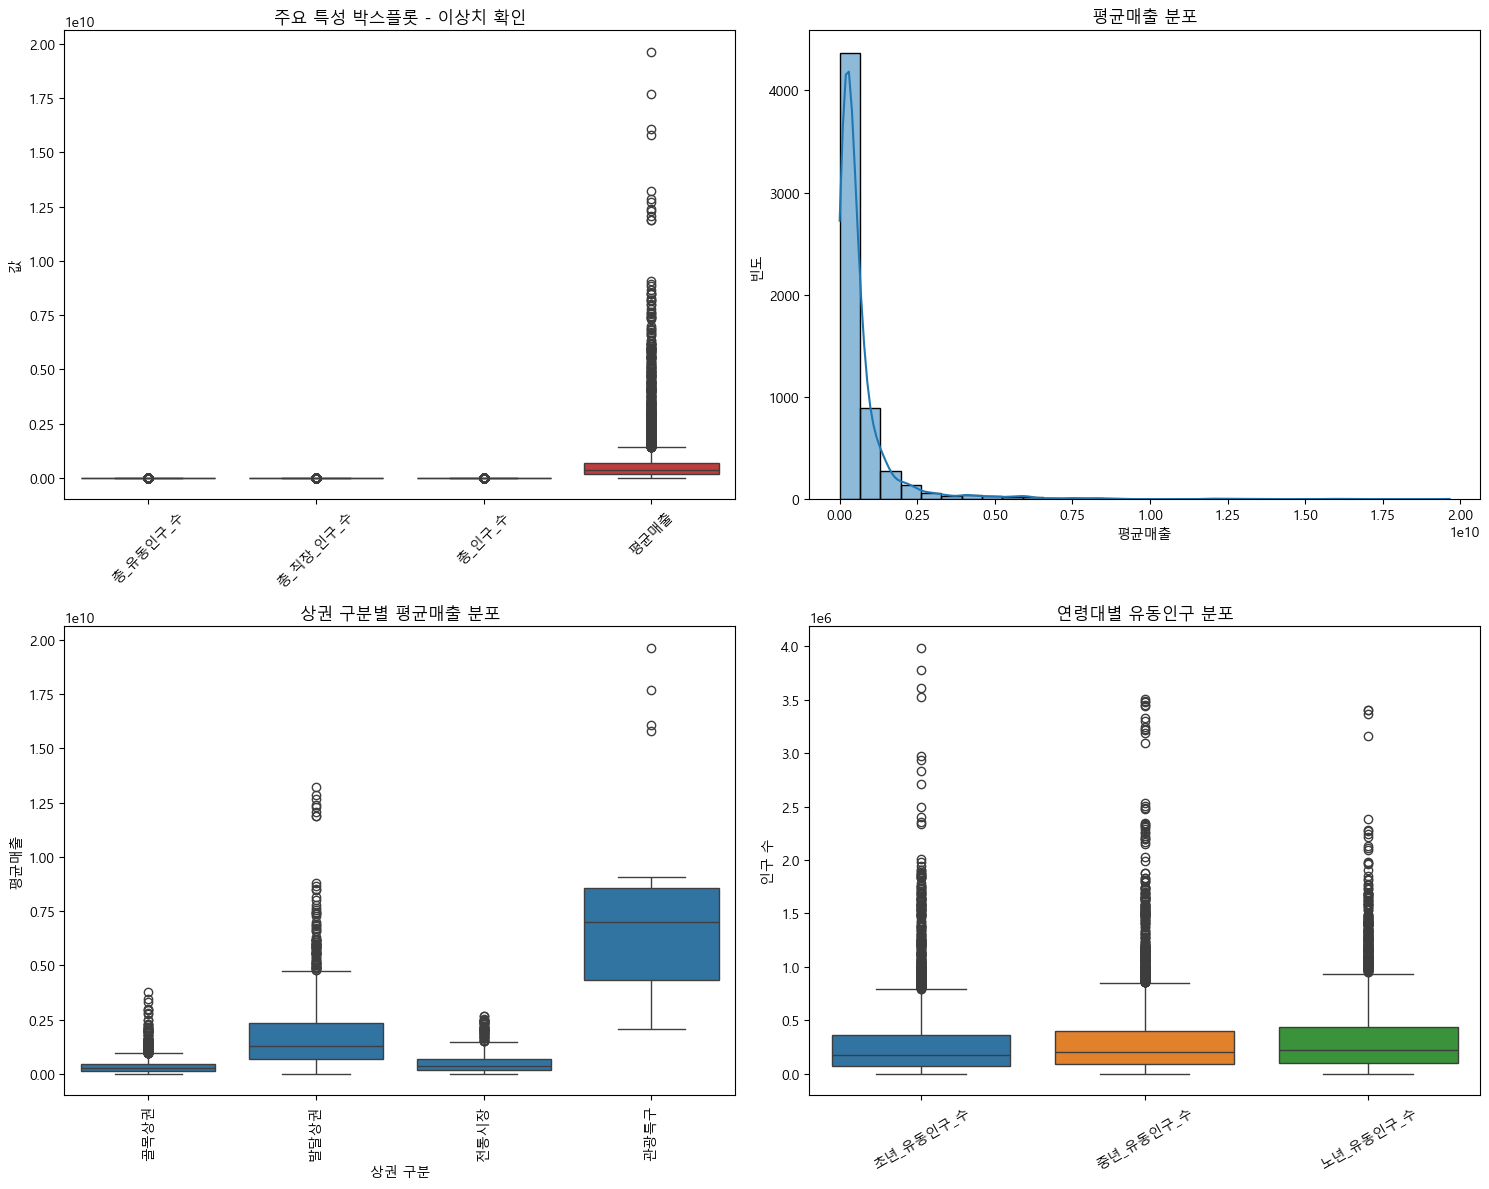

In [161]:
# 주요 수치형 특성의 분포와 이상치 확인
key_features = ['총_유동인구_수', '총_직장_인구_수', '총_인구_수', '평균매출']

# 1. 박스플롯으로 이상치 확인
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
sns.boxplot(data=feature_engineering_df[key_features])
plt.title('주요 특성 박스플롯 - 이상치 확인')
plt.xticks(rotation=45)
plt.ylabel('값')

# 2. 평균매출 분포 - 히스토그램
plt.subplot(2, 2, 2)
sns.histplot(feature_engineering_df['평균매출'], kde=True, bins=30)
plt.title('평균매출 분포')
plt.xlabel('평균매출')
plt.ylabel('빈도')

# 3. 상권 구분별 매출 분포 - 박스플롯
plt.subplot(2, 2, 3)
sns.boxplot(x='상권_구분_코드_명', y='평균매출', data=feature_engineering_df)
plt.title('상권 구분별 평균매출 분포')
plt.xlabel('상권 구분')
plt.ylabel('평균매출')
plt.xticks(rotation=90)

# 4. 연령대별 유동인구 분포
plt.subplot(2, 2, 4)
age_cols = ["초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수"]
sns.boxplot(data=feature_engineering_df[age_cols])
plt.title("연령대별 유동인구 분포")
plt.ylabel("인구 수")
plt.xticks(rotation=30)

plt.tight_layout()
plt.savefig('plots/data_distribution_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.6 로그 변환 효과 분석

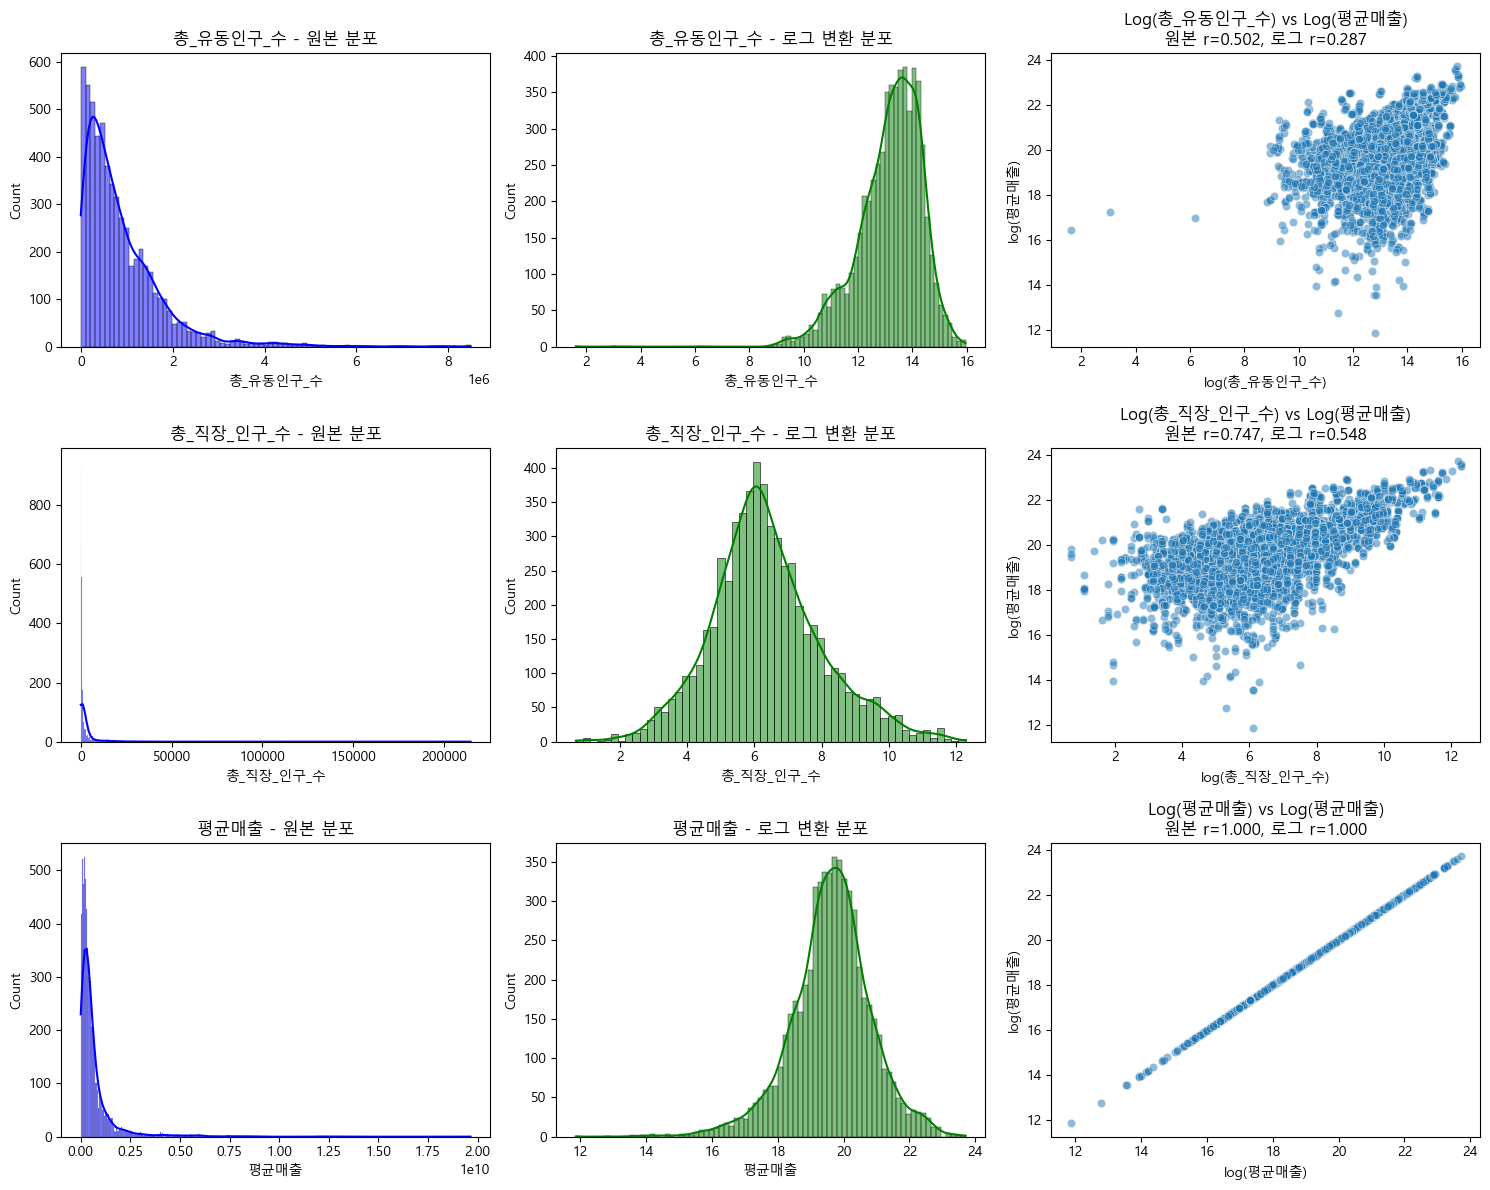

In [162]:
# 주요 특성들에 대한 로그 변환 전/후 비교 시각화
plt.figure(figsize=(15, 12))

# 변환 대상 특성 선택
transformation_features = ['총_유동인구_수', '총_직장_인구_수', '평균매출']

for i, feature in enumerate(transformation_features):
    # 1. 원본 데이터 분포
    plt.subplot(len(transformation_features), 3, i*3+1)
    sns.histplot(feature_engineering_df[feature], kde=True, color='blue')
    plt.title(f'{feature} - 원본 분포')
    
    # 2. 로그 변환 분포
    plt.subplot(len(transformation_features), 3, i*3+2)
    log_data = np.log1p(feature_engineering_df[feature])
    sns.histplot(log_data, kde=True, color='green')
    plt.title(f'{feature} - 로그 변환 분포')
    
    # 3. 변환 전후 타겟 상관관계 비교
    plt.subplot(len(transformation_features), 3, i*3+3)
    
    # 원본 데이터 상관계수 계산
    orig_corr = feature_engineering_df[feature].corr(feature_engineering_df['평균매출'])
    # 로그 변환 데이터 상관계수 계산
    log_corr = np.log1p(feature_engineering_df[feature]).corr(np.log1p(feature_engineering_df['평균매출']))
    
    # 로그-로그 스케일 산점도 (일반적으로 더 선형적 관계를 보임)
    sns.scatterplot(x=np.log1p(feature_engineering_df[feature]), 
                   y=np.log1p(feature_engineering_df['평균매출']), 
                   alpha=0.5)
    plt.title(f'Log({feature}) vs Log(평균매출)\n원본 r={orig_corr:.3f}, 로그 r={log_corr:.3f}')
    plt.xlabel(f'log({feature})')
    plt.ylabel('log(평균매출)')

plt.tight_layout()
plt.savefig('plots/log_transformation_effect.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.7 주요 특성과 타겟 변수의 관계

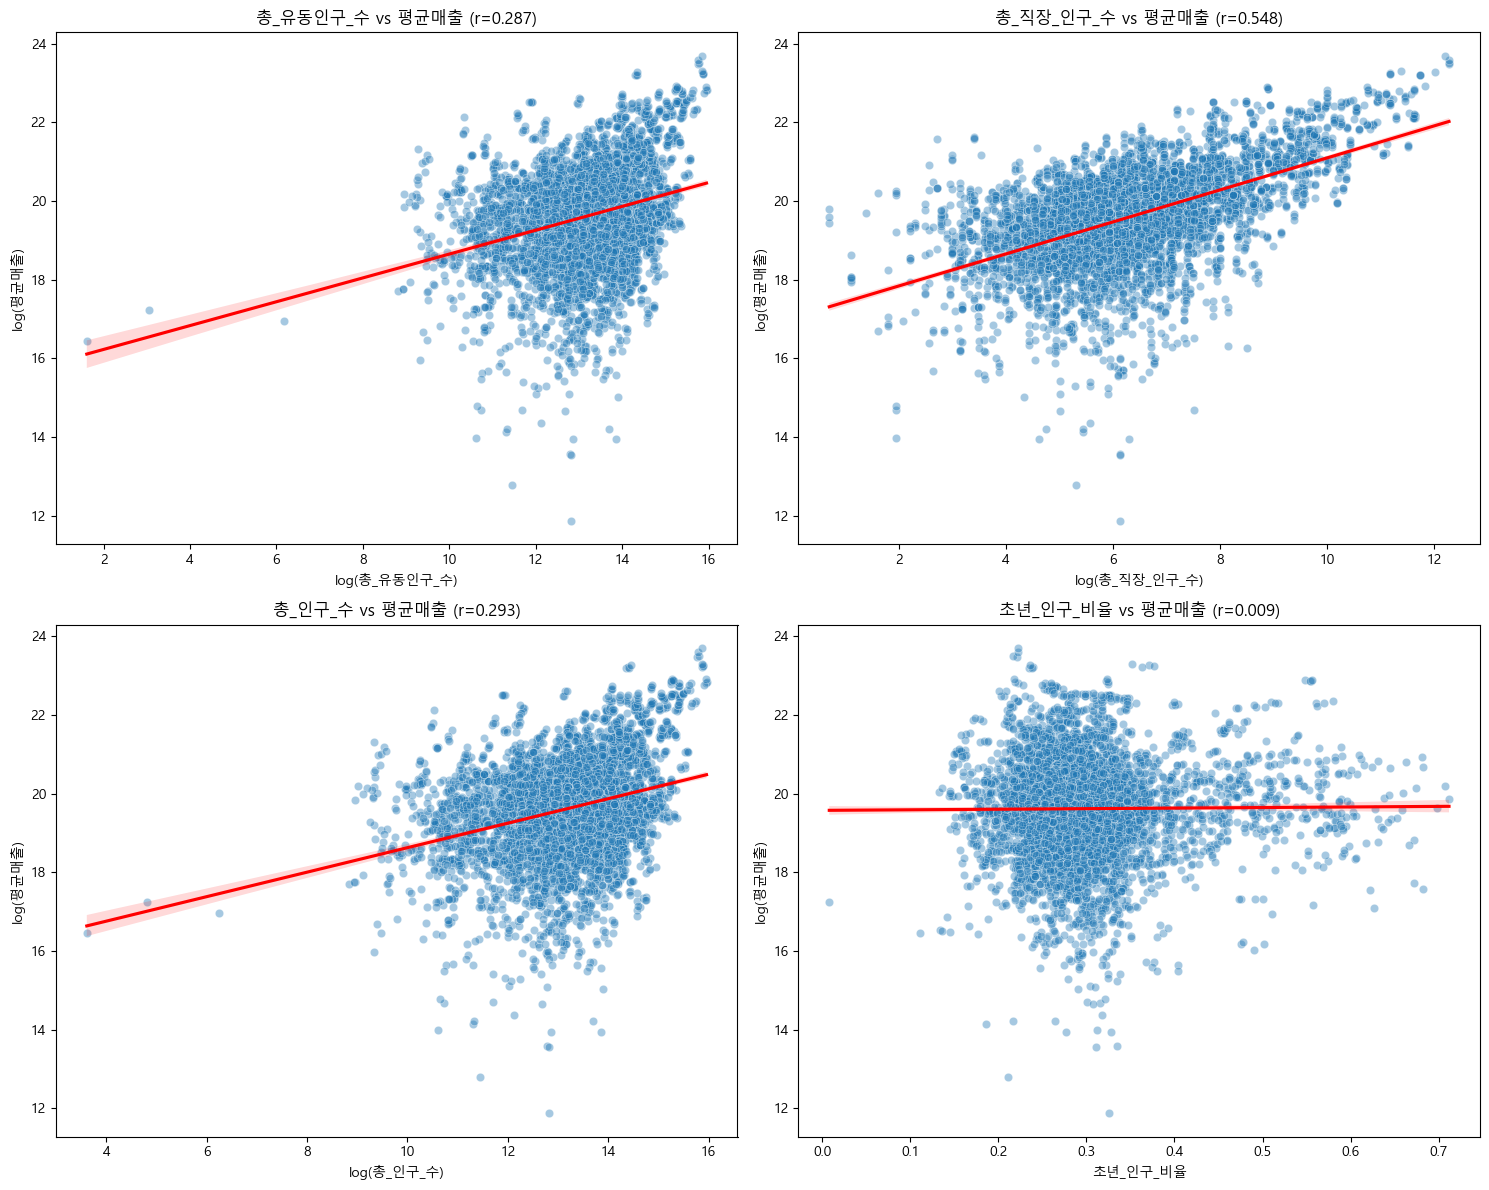

In [163]:
# 주요 특성과 타겟 변수의 관계 시각화 (로그 변환 적용)
plt.figure(figsize=(15, 12))

# 상관관계가 높을 것으로 예상되는 주요 특성들과 타겟 변수 '평균매출'의 관계
key_relationships = [
    ('총_유동인구_수', '평균매출'), 
    ('총_직장_인구_수', '평균매출'),
    ('총_인구_수', '평균매출'),
    ('초년_인구_비율', '평균매출')
]

for i, (feature, target) in enumerate(key_relationships):
    plt.subplot(2, 2, i+1)
    
    # 로그 변환 적용 (인구 비율 제외)
    if '비율' not in feature:
        x_data = np.log1p(feature_engineering_df[feature])
        x_label = f'log({feature})'
        y_data = np.log1p(feature_engineering_df[target])
        y_label = f'log({target})'
    else:
        x_data = feature_engineering_df[feature]
        x_label = feature
        y_data = np.log1p(feature_engineering_df[target])
        y_label = f'log({target})'
    
    # 산점도와 회귀선
    sns.scatterplot(x=x_data, y=y_data, alpha=0.4)
    sns.regplot(x=x_data, y=y_data, scatter=False, line_kws={"color":"red"})
    
    # 상관계수 계산 및 표시
    corr = x_data.corr(y_data)
    plt.title(f'{feature} vs {target} (r={corr:.3f})')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

plt.tight_layout()
plt.savefig('plots/key_feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

# 로그 변환된 특성 생성
for feature in transformation_features:
    if feature in numeric_feature_candidates and feature != '평균매출':  # 타겟 변수는 제외
        feature_engineering_df[f'log_{feature}'] = np.log1p(feature_engineering_df[feature])
        numeric_feature_candidates.append(f'log_{feature}')

## 3. 특성 간 상관관계 분석

### 3.1 상관계수 계산 및 분석

In [164]:
# 상관계수 계산을 위한 데이터프레임 준비
# 수치형 특성과 타겟 변수만 선택
correlation_data = feature_engineering_df[numeric_feature_candidates + ['평균매출']]

# 상관계수 계산 - 모든 변수 쌍 간의 피어슨 상관계수
correlation_matrix = correlation_data.corr()
# 타겟 변수('평균매출')와의 상관관계 추출 후 절대값 기준 내림차순 정렬
correlation_with_target = correlation_matrix['평균매출'].abs().sort_values(ascending=False)

### 3.2 매출과의 상관관계 출력

In [165]:
# 평균 매출과 상관관계가 높은 특성 확인 (절대값 기준)
print("\n평균 매출과 상관관계가 있는 특성 (절대값 기준 내림차순):")
display(correlation_with_target)


평균 매출과 상관관계가 있는 특성 (절대값 기준 내림차순):


평균매출                 1.000000
여성_직장_인구_수           0.761111
연령대_20_직장_인구_수       0.748536
초년_직장_인구_수           0.748435
총_직장_인구_수            0.747404
중년_직장_인구_수           0.740826
연령대_30_직장_인구_수       0.740468
연령대_40_직장_인구_수       0.738426
노년_직장_인구_수           0.735182
남성_직장_인구_수           0.730130
연령대_50_직장_인구_수       0.730063
연령대_60_이상_직장_인구_수    0.714936
연령대_30_유동인구_수        0.604414
중년_유동인구_수            0.595137
연령대_40_유동인구_수        0.573067
연령대_10_직장_인구_수       0.567904
log_총_직장_인구_수        0.547232
남성_유동인구_수            0.522125
연령대_20_유동인구_수        0.521051
총_인구_수               0.509168
총_유동인구_수             0.501849
여성_유동인구_수            0.479406
초년_유동인구_수            0.465835
연령대_50_유동인구_수        0.455800
노년_유동인구_수            0.359449
연령대_60_이상_유동인구_수     0.284804
log_총_유동인구_수         0.277774
연령대_10_유동인구_수        0.243507
여성_인구_비율             0.196269
남성_유동인구_비율           0.172665
여성_유동인구_비율           0.172593
유동인구_직장인구_비율         0.097667
초년_인구_비율             0.005583
여성_직장인구_비율

### 3.3 상관계수 히트맵

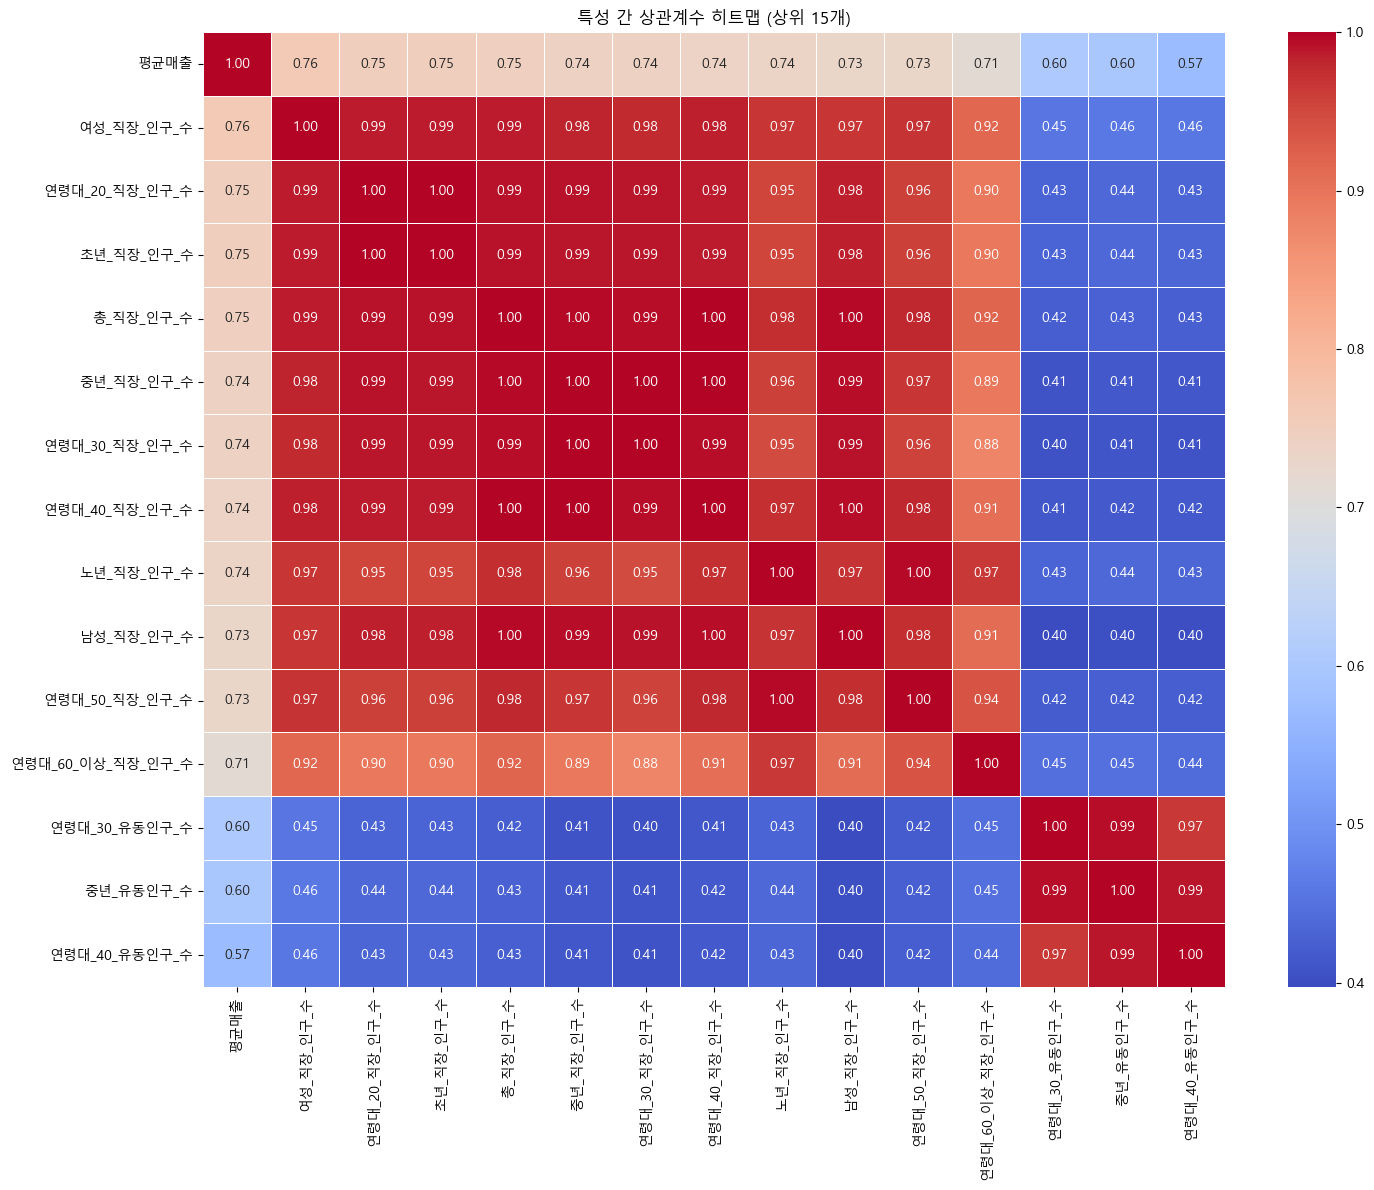

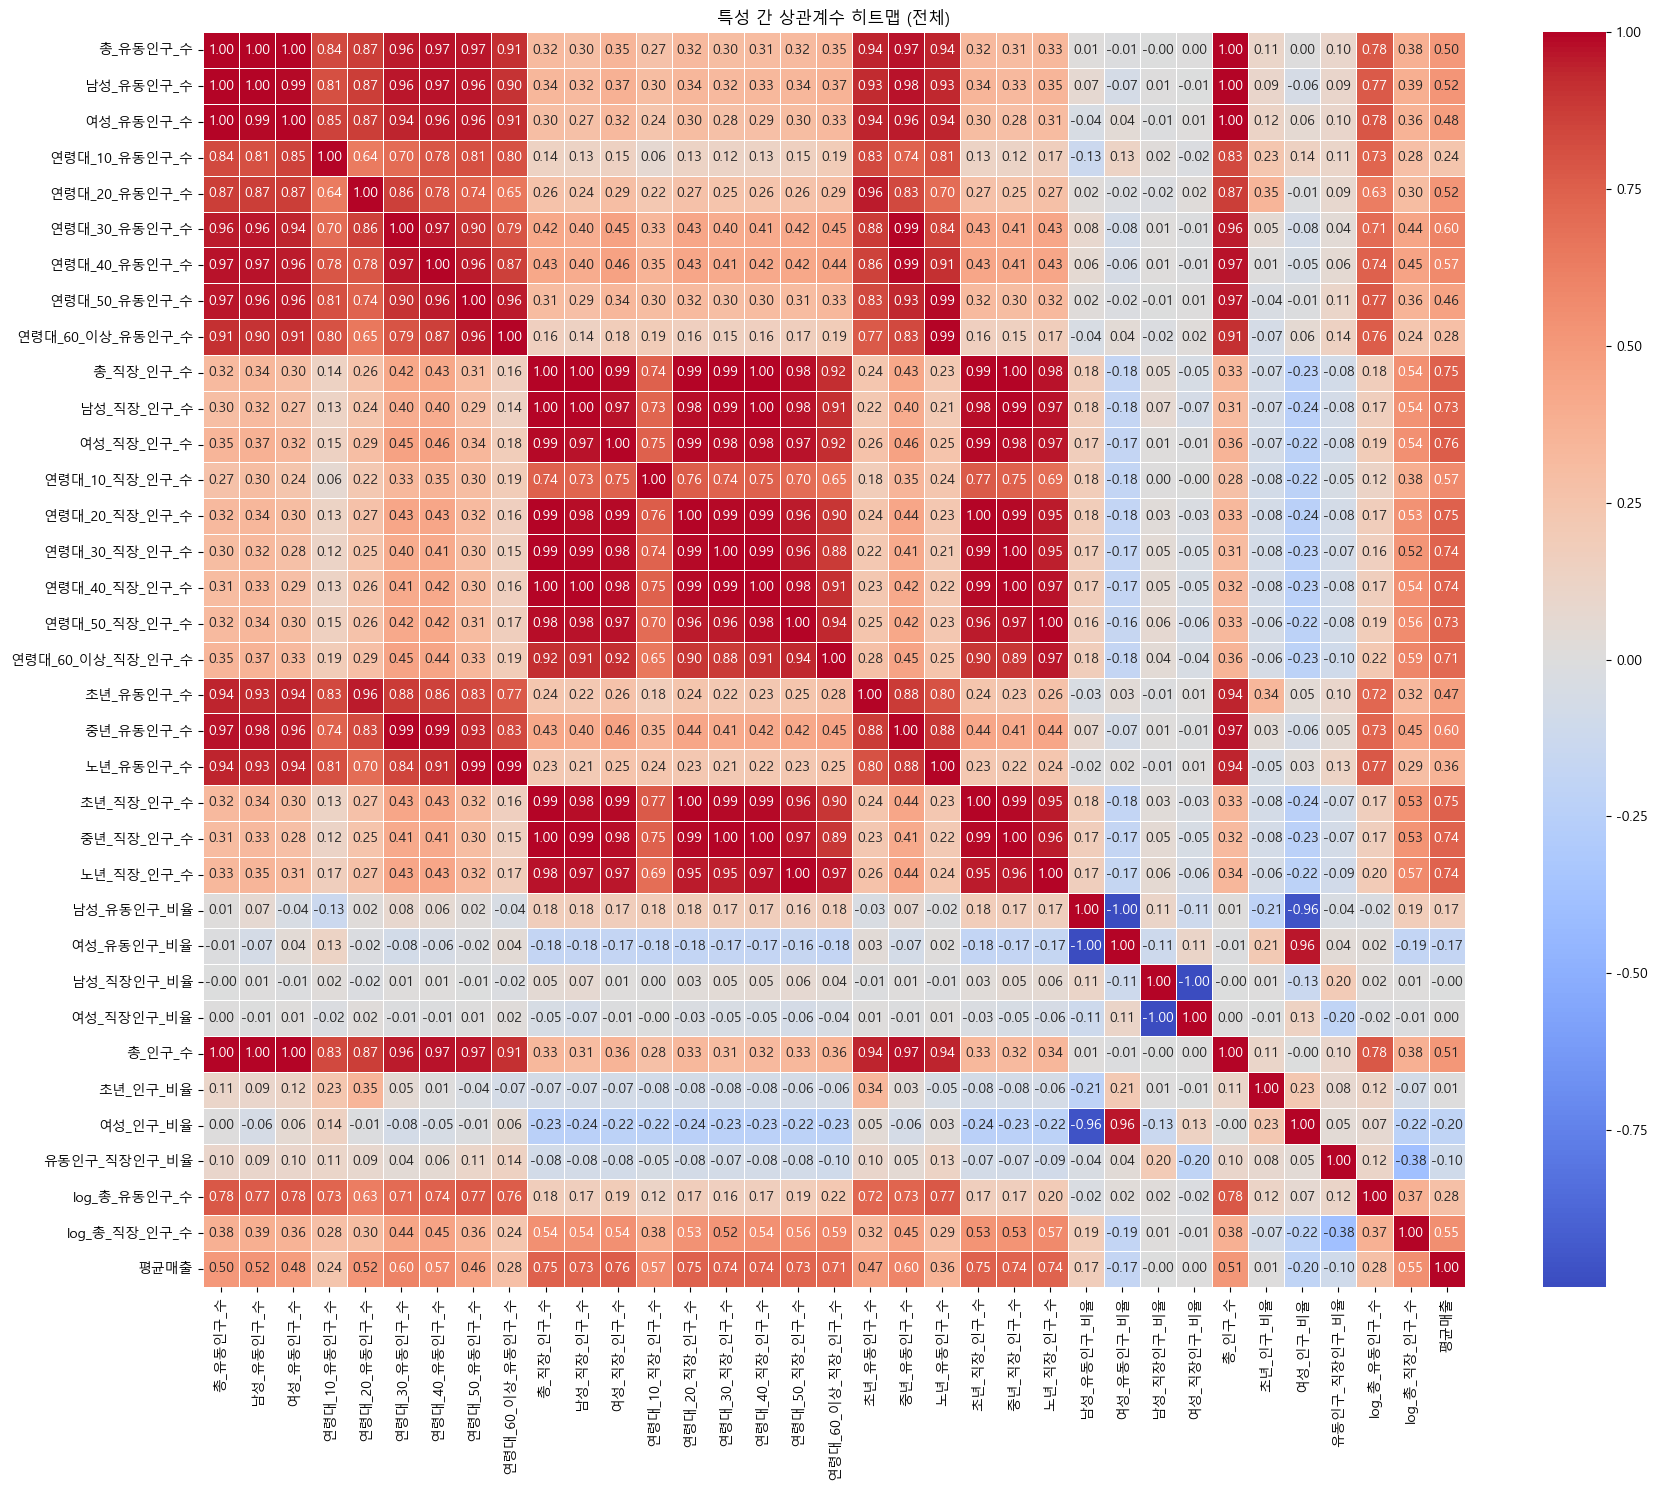

In [166]:
# 상관계수 히트맵 - 상위 15개 특성 간의 상관관계 시각화
top_features = correlation_with_target.index[:15]  # 상위 15개 특성 선택

plt.figure(figsize=(15, 12))
# 히트맵 그리기 (상위 15개 특성만)
sns.heatmap(correlation_matrix.loc[top_features, top_features], 
            annot=True,          # 값 표시
            cmap='coolwarm',     # 색상맵 (양수: 빨강, 음수: 파랑)
            fmt='.2f',           # 소수점 2자리까지 표시
            linewidths=0.5)      # 경계선 두께
plt.title('특성 간 상관계수 히트맵 (상위 15개)')
plt.tight_layout()
plt.savefig('plots/correlation_heatmap_top15.png', dpi=300, bbox_inches='tight')
plt.show()

# 상관계수 히트맵 - 전체 특성 간의 상관관계 시각화
plt.figure(figsize=(18, 15))
# 히트맵 그리기 (전체 특성)
sns.heatmap(correlation_matrix, 
            annot=True,          # 값 표시
            cmap='coolwarm',     # 색상맵 (양수: 빨강, 음수: 파랑)
            fmt='.2f',           # 소수점 2자리까지 표시
            linewidths=0.5)      # 경계선 두께
plt.title('특성 간 상관계수 히트맵 (전체)')
plt.tight_layout()
plt.savefig('plots/correlation_heatmap_all.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.4 다중공선성 확인

In [167]:
# 다중공선성이 있는 특성 쌍 확인 (상관계수 0.8 이상)
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # 0.8은 임계값
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            high_correlation_pairs.append((col_i, col_j, corr_value))

if high_correlation_pairs:
    print("\n높은 상관관계를 가진 특성 쌍 (상관계수 > 0.8):")
    for pair in high_correlation_pairs:
        print(f"- {pair[0]} - {pair[1]}: {pair[2]:.4f}")
else:
    print("\n상관계수 0.8 이상의 높은 상관관계를 가진 특성 쌍이 없습니다.")


높은 상관관계를 가진 특성 쌍 (상관계수 > 0.8):
- 총_유동인구_수 - 남성_유동인구_수: 0.9960
- 총_유동인구_수 - 여성_유동인구_수: 0.9965
- 총_유동인구_수 - 연령대_10_유동인구_수: 0.8350
- 총_유동인구_수 - 연령대_20_유동인구_수: 0.8715
- 총_유동인구_수 - 연령대_30_유동인구_수: 0.9553
- 총_유동인구_수 - 연령대_40_유동인구_수: 0.9694
- 총_유동인구_수 - 연령대_50_유동인구_수: 0.9660
- 총_유동인구_수 - 연령대_60_이상_유동인구_수: 0.9091
- 총_유동인구_수 - 초년_유동인구_수: 0.9385
- 총_유동인구_수 - 중년_유동인구_수: 0.9699
- 총_유동인구_수 - 노년_유동인구_수: 0.9418
- 총_유동인구_수 - 총_인구_수: 0.9999
- 남성_유동인구_수 - 여성_유동인구_수: 0.9850
- 남성_유동인구_수 - 연령대_10_유동인구_수: 0.8101
- 남성_유동인구_수 - 연령대_20_유동인구_수: 0.8692
- 남성_유동인구_수 - 연령대_30_유동인구_수: 0.9622
- 남성_유동인구_수 - 연령대_40_유동인구_수: 0.9733
- 남성_유동인구_수 - 연령대_50_유동인구_수: 0.9642
- 남성_유동인구_수 - 연령대_60_이상_유동인구_수: 0.8986
- 남성_유동인구_수 - 초년_유동인구_수: 0.9275
- 남성_유동인구_수 - 중년_유동인구_수: 0.9755
- 남성_유동인구_수 - 노년_유동인구_수: 0.9349
- 남성_유동인구_수 - 총_인구_수: 0.9962
- 여성_유동인구_수 - 연령대_10_유동인구_수: 0.8522
- 여성_유동인구_수 - 연령대_20_유동인구_수: 0.8673
- 여성_유동인구_수 - 연령대_30_유동인구_수: 0.9421
- 여성_유동인구_수 - 연령대_40_유동인구_수: 0.9589
- 여성_유동인구_수 - 연령대_50_유동인구_수: 0.9606
- 여성_유동인구_수 - 연령

## 4. 최종 특성 선택

### 4.1 특성 선택 기준 및 최종 특성 정의

In [168]:
# 상관관계 분석 결과를 바탕으로 최종 특성 선택
# 1. 타겟 변수와의 상관관계가 높은 특성 선택
# 2. 다중공선성을 고려하여 최종 특성 목록 조정

# 타겟 변수와의 상관관계가 높은 상위 특성들 중에서 선택
top_correlated_features = correlation_with_target.iloc[1:11].index.tolist()  # 평균매출 제외하고 상위 10개 선택

# 다중공선성을 고려하여 최종 특성 목록 조정
# 예: 총_유동인구_수와 남성_유동인구_수 중 더 상관관계가 높은 것 선택
# 이 과정은 상관관계 결과에 따라 수동으로 조정 필요

# 최종 선택된 수치형 특성
numeric_features = [
    "총_유동인구_수", "남성_유동인구_수", "여성_유동인구_수", 
    "총_직장_인구_수", "남성_직장_인구_수", "여성_직장_인구_수", 
    "초년_유동인구_수", "중년_유동인구_수", "노년_유동인구_수", 
    "초년_직장_인구_수", "중년_직장_인구_수", "노년_직장_인구_수"
]

# 범주형 특성 - 원핫인코딩 될 변수들
categorical_features = ["상권_구분_코드_명", "기준_년분기_코드"]

# 최종 데이터셋 형태 확인
print(f"\n최종 데이터셋 형태: {feature_engineering_df.shape[0]:,}행 x {feature_engineering_df.shape[1]:,}열")
print("\n선택된 특성 목록:")
print(f"- 수치형 특성({len(numeric_features)}개): {', '.join(numeric_features)}")
print(f"- 범주형 특성({len(categorical_features)}개): {', '.join(categorical_features)}")
print(f"- 타겟 변수: 평균매출")

# 필요한 열만 선택하여 최종 데이터셋 생성 
restaurant_data = feature_engineering_df[numeric_features + categorical_features + ["평균매출"]]


최종 데이터셋 형태: 5,915행 x 69열

선택된 특성 목록:
- 수치형 특성(12개): 총_유동인구_수, 남성_유동인구_수, 여성_유동인구_수, 총_직장_인구_수, 남성_직장_인구_수, 여성_직장_인구_수, 초년_유동인구_수, 중년_유동인구_수, 노년_유동인구_수, 초년_직장_인구_수, 중년_직장_인구_수, 노년_직장_인구_수
- 범주형 특성(2개): 상권_구분_코드_명, 기준_년분기_코드
- 타겟 변수: 평균매출


## 5. 전처리 파이프라인 구성

### 5.1 전처리 파이프라인 정의

In [169]:
# 수치형/범주형 특성 전처리 파이프라인 구성
preprocessor = ColumnTransformer(
    transformers=[
        # 수치형 특성 처리 파이프라인: 결측치 대체 후 표준화
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),  # 결측치는 중앙값으로 대체
            ('scaler', StandardScaler())                   # 평균 0, 표준편차 1로 스케일링
        ]), numeric_features),
        
        # 범주형 특성 처리 파이프라인: 결측치 대체 후 원핫인코딩
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # 결측치는 최빈값으로 대체
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # 원핫인코딩
        ]), categorical_features)
    ])

### 5.2 데이터 준비 및 변환

In [170]:
# 특성과 타겟 분리
X = restaurant_data[numeric_features + categorical_features]
y = restaurant_data["평균매출"]

# 전처리 파이프라인으로 데이터 변환
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)

# 변환된 데이터 차원 확인
print(f"\n변환된 특성 행렬 형태: {X_transformed.shape[0]:,}행 x {X_transformed.shape[1]:,}열")


변환된 특성 행렬 형태: 5,915행 x 20열


### 5.3 변환된 특성 이름 추출

In [171]:
# 변환된 특성 이름 추출
transformed_feature_names = numeric_features.copy()  # 수치형 특성 이름은 그대로 유지

# 범주형 특성의 원핫인코딩 이름 추가
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features)
transformed_feature_names.extend(categorical_feature_names)

# 변환된 데이터를 데이터프레임으로 변환
transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)
transformed_df["평균매출"] = y  # 타겟 변수 추가

# 변환된 데이터 확인
print(f"\n변환된 데이터프레임 형태: {transformed_df.shape[0]:,}행 x {transformed_df.shape[1]:,}열")
print(f"원핫인코딩 후 생성된 범주형 특성: {len(categorical_feature_names)}개")
print("\n변환된 데이터 샘플:")
print(transformed_df.head(3))


변환된 데이터프레임 형태: 5,915행 x 21열
원핫인코딩 후 생성된 범주형 특성: 8개

변환된 데이터 샘플:
   총_유동인구_수  남성_유동인구_수  여성_유동인구_수  총_직장_인구_수  남성_직장_인구_수  여성_직장_인구_수  \
0  0.148718   0.017613   0.269327  -0.251002   -0.245211   -0.255584   
1  0.198066   0.017435   0.364285  -0.251002   -0.245211   -0.255584   
2  0.105271  -0.033069   0.232911  -0.251002   -0.245211   -0.255584   

   초년_유동인구_수  중년_유동인구_수  노년_유동인구_수  초년_직장_인구_수  ...  노년_직장_인구_수  \
0   0.124142  -0.046244   0.363503   -0.244779  ...   -0.260126   
1   0.241624  -0.060403   0.406923   -0.244779  ...   -0.260126   
2   0.043690  -0.081144   0.354146   -0.244779  ...   -0.260126   

   상권_구분_코드_명_골목상권  상권_구분_코드_명_관광특구  상권_구분_코드_명_발달상권  상권_구분_코드_명_전통시장  \
0              1.0              0.0              0.0              0.0   
1              1.0              0.0              0.0              0.0   
2              1.0              0.0              0.0              0.0   

   기준_년분기_코드_20241  기준_년분기_코드_20242  기준_년분기_코드_20243  기준_년분기_코드_20244  \
0          

## 6. 특성 간 상관관계 분석

### 6.1 상관계수 계산 및 분석

In [172]:
# 상관계수 계산 - 모든 변수 쌍 간의 피어슨 상관계수
correlation_matrix = transformed_df.corr()
# 타겟 변수('평균매출')와의 상관관계 추출 후 절대값 기준 내림차순 정렬
correlation_with_target = correlation_matrix['평균매출'].abs().sort_values(ascending=False)

### 6.2 매출과의 상관관계 출력

In [173]:
# 평균 매출과 상관관계가 높은 특성 확인 (절대값 기준)
print("\n평균 매출과 상관관계가 있는 특성 (절대값 기준 내림차순):")
display(correlation_with_target)


평균 매출과 상관관계가 있는 특성 (절대값 기준 내림차순):


평균매출               1.000000
여성_직장_인구_수         0.761111
초년_직장_인구_수         0.748435
총_직장_인구_수          0.747404
중년_직장_인구_수         0.740826
노년_직장_인구_수         0.735182
남성_직장_인구_수         0.730130
중년_유동인구_수          0.595137
남성_유동인구_수          0.522125
총_유동인구_수           0.501849
상권_구분_코드_명_발달상권    0.479810
여성_유동인구_수          0.479406
초년_유동인구_수          0.465835
상권_구분_코드_명_관광특구    0.388701
상권_구분_코드_명_골목상권    0.384984
노년_유동인구_수          0.359449
상권_구분_코드_명_전통시장    0.058360
기준_년분기_코드_20244    0.014116
기준_년분기_코드_20241    0.011922
기준_년분기_코드_20243    0.008589
기준_년분기_코드_20242    0.006392
Name: 평균매출, dtype: float64

### 6.3 상관계수 히트맵

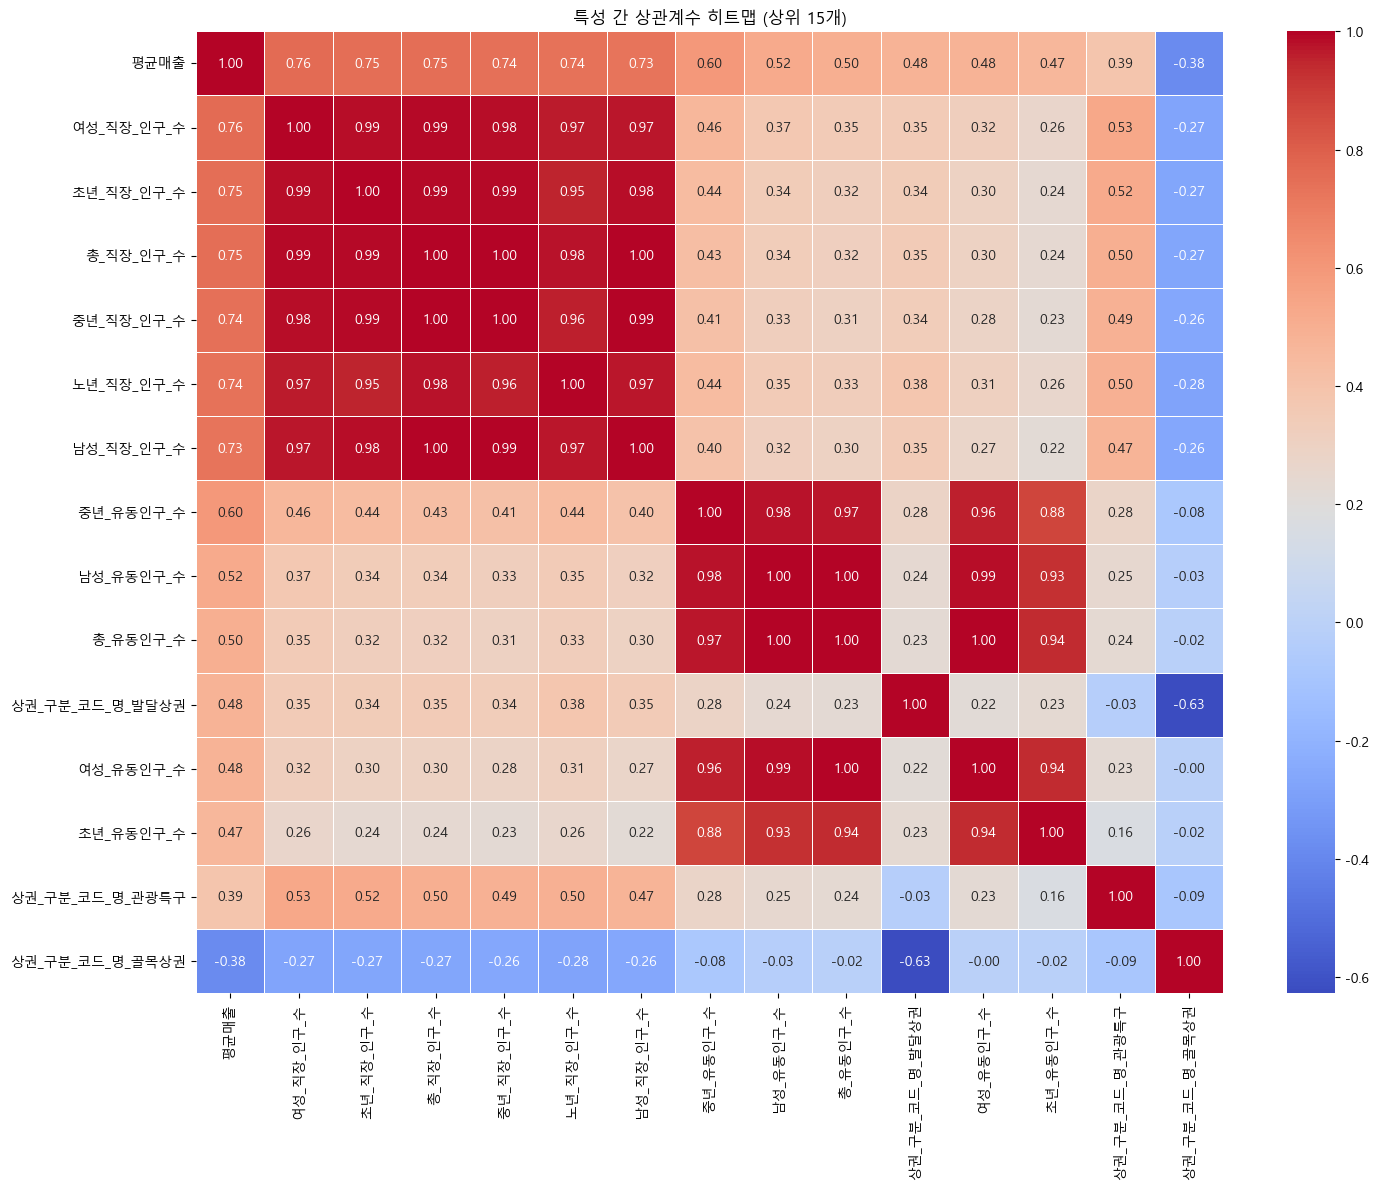

In [174]:
# 상관계수 히트맵 - 상위 15개 특성 간의 상관관계 시각화
top_features = correlation_with_target.index[:15]  # 상위 15개 특성 선택

plt.figure(figsize=(15, 12))
# 히트맵 그리기 (상위 15개 특성만)
sns.heatmap(correlation_matrix.loc[top_features, top_features], 
            annot=True,          # 값 표시
            cmap='coolwarm',     # 색상맵 (양수: 빨강, 음수: 파랑)
            fmt='.2f',           # 소수점 2자리까지 표시
            linewidths=0.5)      # 경계선 두께
plt.title('특성 간 상관계수 히트맵 (상위 15개)')
plt.tight_layout()
plt.savefig('plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.4 다중공선성 확인

In [175]:
# 다중공선성이 있는 특성 쌍 확인 (상관계수 0.8 이상)
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # 0.8은 임계값
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            high_correlation_pairs.append((col_i, col_j, corr_value))

if high_correlation_pairs:
    print("\n높은 상관관계를 가진 특성 쌍 (상관계수 > 0.8):")
    for pair in high_correlation_pairs:
        print(f"- {pair[0]} - {pair[1]}: {pair[2]:.4f}")
else:
    print("\n상관계수 0.8 이상의 높은 상관관계를 가진 특성 쌍이 없습니다.")


높은 상관관계를 가진 특성 쌍 (상관계수 > 0.8):
- 총_유동인구_수 - 남성_유동인구_수: 0.9960
- 총_유동인구_수 - 여성_유동인구_수: 0.9965
- 총_유동인구_수 - 초년_유동인구_수: 0.9385
- 총_유동인구_수 - 중년_유동인구_수: 0.9699
- 총_유동인구_수 - 노년_유동인구_수: 0.9418
- 남성_유동인구_수 - 여성_유동인구_수: 0.9850
- 남성_유동인구_수 - 초년_유동인구_수: 0.9275
- 남성_유동인구_수 - 중년_유동인구_수: 0.9755
- 남성_유동인구_수 - 노년_유동인구_수: 0.9349
- 여성_유동인구_수 - 초년_유동인구_수: 0.9419
- 여성_유동인구_수 - 중년_유동인구_수: 0.9578
- 여성_유동인구_수 - 노년_유동인구_수: 0.9415
- 총_직장_인구_수 - 남성_직장_인구_수: 0.9955
- 총_직장_인구_수 - 여성_직장_인구_수: 0.9880
- 총_직장_인구_수 - 초년_직장_인구_수: 0.9922
- 총_직장_인구_수 - 중년_직장_인구_수: 0.9973
- 총_직장_인구_수 - 노년_직장_인구_수: 0.9763
- 남성_직장_인구_수 - 여성_직장_인구_수: 0.9690
- 남성_직장_인구_수 - 초년_직장_인구_수: 0.9837
- 남성_직장_인구_수 - 중년_직장_인구_수: 0.9950
- 남성_직장_인구_수 - 노년_직장_인구_수: 0.9700
- 여성_직장_인구_수 - 초년_직장_인구_수: 0.9869
- 여성_직장_인구_수 - 중년_직장_인구_수: 0.9819
- 여성_직장_인구_수 - 노년_직장_인구_수: 0.9677
- 초년_유동인구_수 - 중년_유동인구_수: 0.8754
- 초년_유동인구_수 - 노년_유동인구_수: 0.8033
- 중년_유동인구_수 - 노년_유동인구_수: 0.8835
- 초년_직장_인구_수 - 중년_직장_인구_수: 0.9903
- 초년_직장_인구_수 - 노년_직장_인구_수: 0.9536
- 중년_직장_인구_수 - 노년_직장_인

## 7. 모델 훈련 및 평가

### 7.1 데이터 분할 및 모델 정의

In [176]:
# 훈련/테스트 데이터 분할 (테스트 데이터 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# 모델 정의 - 다양한 회귀 모델로 비교 분석
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Polynomial Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=2)),  # 다항식 특성 생성 (2차)
        ('regressor', LinearRegression())
    ]),
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0, tol=1)) # L2 정규화
    ]),
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=1.0, max_iter=8000, tol=1e-3))  # L1 정규화
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, max_depth=None, random_state=RANDOM_STATE))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE))
    ])
}

# 결과 저장용 리스트
results = []

### 7.2 모델 훈련 및 평가

In [177]:
# 각 모델 학습 및 평가
for name, model in models.items():
    print(f"\n{name} 모델 학습 중...")
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 교차 검증 수행 (5-fold)
    print("교차 검증 중...")
    # RMSE 점수 계산 (음수로 반환되므로 부호 변경)
    cv_rmse_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    # R² 점수 계산
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    # MAE 점수 계산 (음수로 반환되므로 부호 변경)
    cv_mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # 교차 검증 결과 출력 (평균 및 표준편차)
    print(f"  CV RMSE: {cv_rmse_scores.mean():.2f} ± {cv_rmse_scores.std():.2f}")
    print(f"  CV R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
    print(f"  CV MAE: {cv_mae_scores.mean():.2f} ± {cv_mae_scores.std():.2f}")
    
    # 훈련 세트 성능 평가
    y_train_pred = model.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 테스트 세트 성능 평가
    y_pred = model.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    # 결과 저장
    results.append({
        'Model': name,
        'Train RMSE': train_rmse,
        'CV RMSE': cv_rmse_scores.mean(),
        'CV RMSE STD': cv_rmse_scores.std(),
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'CV MAE': cv_mae_scores.mean(),
        'Test MAE': test_mae,
        'Train R2': train_r2,
        'CV R2': cv_r2_scores.mean(),
        'Test R2': test_r2
    })
    
    # 훈련 및 테스트 세트 성능 출력
    print(f"- 훈련 세트: RMSE={train_rmse:.2f}, MAE={train_mae:.2f}, R2={train_r2:.4f}")
    print(f"- 테스트 세트: RMSE={test_rmse:.2f}, MAE={test_mae:.2f}, R2={test_r2:.4f}")


Linear Regression 모델 학습 중...
교차 검증 중...
  CV RMSE: 603393117.46 ± 43140719.22
  CV R²: 0.7313 ± 0.0352
  CV MAE: 363863700.71 ± 15981884.12
- 훈련 세트: RMSE=593323798.69, MAE=360020478.54, R2=0.7459
- 테스트 세트: RMSE=628522603.59, MAE=366785674.54, R2=0.6470

Polynomial Regression 모델 학습 중...
교차 검증 중...
  CV RMSE: 3425324707.83 ± 3414358686.20
  CV R²: -15.6570 ± 23.6178
  CV MAE: 442835019.06 ± 113633412.02
- 훈련 세트: RMSE=464966491.11, MAE=296062344.11, R2=0.8440
- 테스트 세트: RMSE=11478695683.05, MAE=815420559.02, R2=-116.7505

Ridge 모델 학습 중...
교차 검증 중...
  CV RMSE: 603188397.80 ± 43289235.29
  CV R²: 0.7315 ± 0.0351
  CV MAE: 363728306.18 ± 16323284.27
- 훈련 세트: RMSE=593588193.73, MAE=360241648.13, R2=0.7457
- 테스트 세트: RMSE=629368198.94, MAE=366393644.82, R2=0.6460

Lasso 모델 학습 중...


D:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.328e+20, tolerance: 6.557e+18
  model = cd_fast.enet_coordinate_descent(


교차 검증 중...


D:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.347e+20, tolerance: 4.955e+18
  model = cd_fast.enet_coordinate_descent(
D:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.339e+20, tolerance: 5.212e+18
  model = cd_fast.enet_coordinate_descent(
D:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

  CV RMSE: 603378275.43 ± 43205662.16
  CV R²: 0.7314 ± 0.0351
  CV MAE: 363823525.02 ± 16260394.59
- 훈련 세트: RMSE=593571882.11, MAE=360250001.27, R2=0.7457
- 테스트 세트: RMSE=629356963.58, MAE=366403849.08, R2=0.6460

Random Forest 모델 학습 중...
교차 검증 중...
  CV RMSE: 371964595.11 ± 63349804.18
  CV R²: 0.8980 ± 0.0250
  CV MAE: 196512447.70 ± 18187537.63
- 훈련 세트: RMSE=122127121.30, MAE=63511235.70, R2=0.9892
- 테스트 세트: RMSE=309044965.40, MAE=169588598.57, R2=0.9146

Gradient Boosting 모델 학습 중...
교차 검증 중...
  CV RMSE: 450437270.33 ± 47267172.41
  CV R²: 0.8498 ± 0.0280
  CV MAE: 281164236.77 ± 13531482.34
- 훈련 세트: RMSE=375531808.63, MAE=252252688.99, R2=0.8982
- 테스트 세트: RMSE=457549474.31, MAE=281770542.52, R2=0.8129


### 7.3 모델 성능 비교


모델 평가 결과 (테스트 RMSE 기준 정렬):


,Model,Train RMSE,CV RMSE,Test RMSE,Train R2,CV R2,Test R2
4,Random Forest,1.221271e+08,3.719646e+08,3.090450e+08,0.989236,0.897991,0.914647
5,Gradient Boosting,3.755318e+08,4.504373e+08,4.575495e+08,0.898224,0.849773,0.812909
0,Linear Regression,5.933238e+08,6.033931e+08,6.285226e+08,0.745941,0.731349,0.646964
3,Lasso,5.935719e+08,6.033783e+08,6.293570e+08,0.745729,0.731370,0.646026
2,Ridge,5.935882e+08,6.031884e+08,6.293682e+08,0.745715,0.731543,0.646013


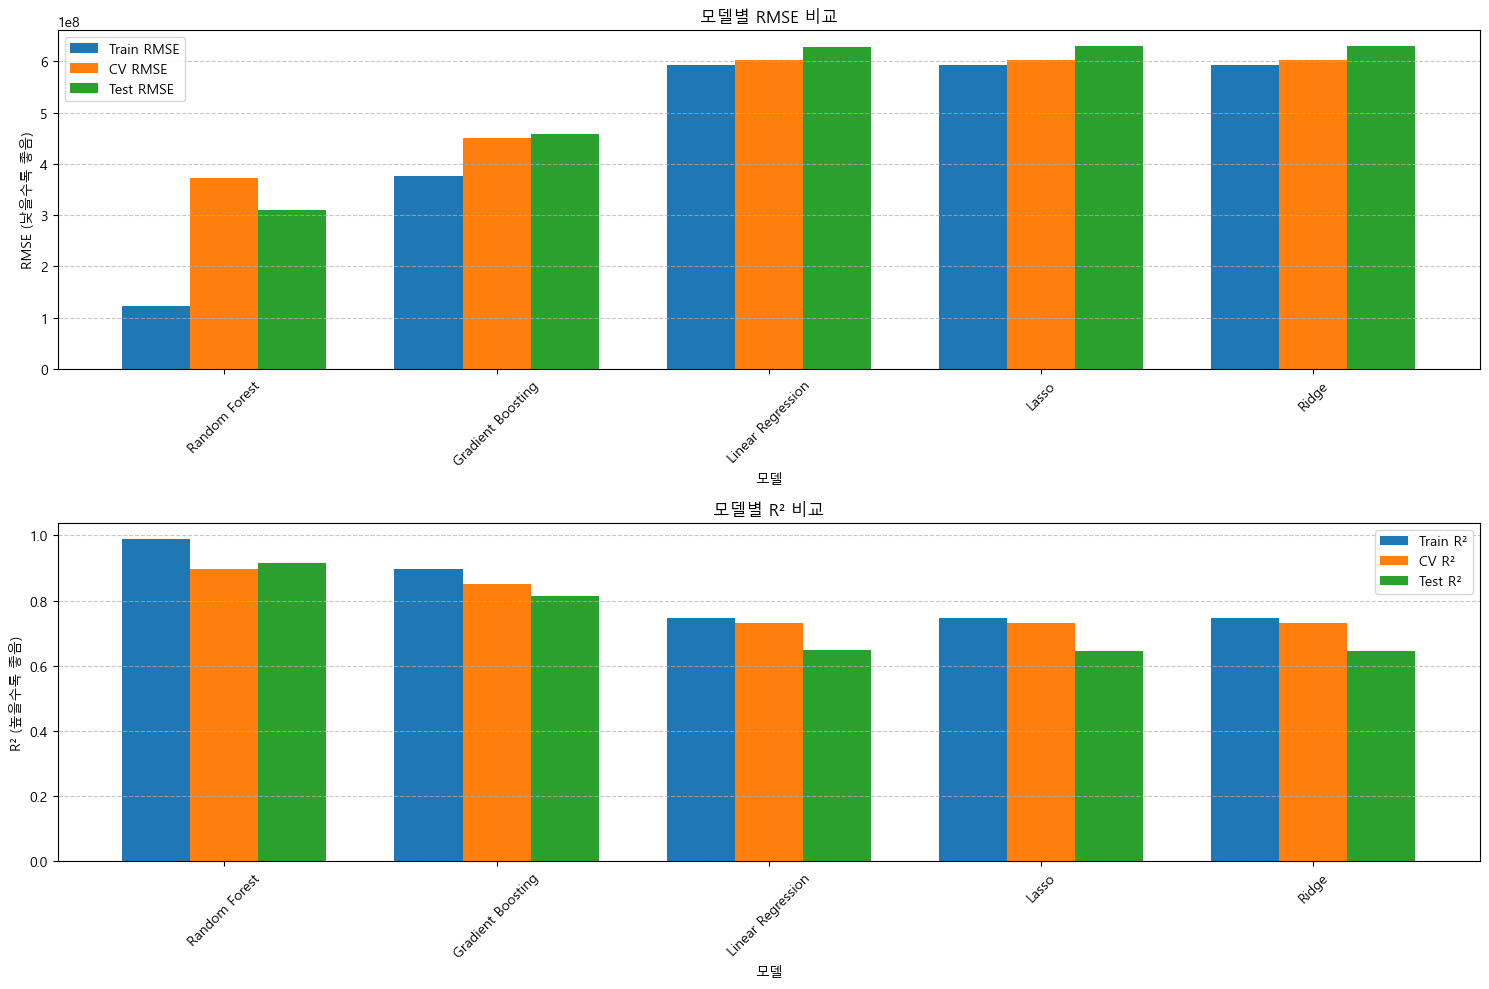


테스트 RMSE 기준 최고 성능 모델: Random Forest
테스트 성능: RMSE=309044965.40, R2=0.9146


In [178]:
# 모델 성능 비교 테이블 생성 (테스트 RMSE 기준 정렬)
results_df = pd.DataFrame(results).sort_values('Test RMSE')

# 폴리노미얼 회귀 모델 제외한 결과 데이터프레임 생성
results_df_filtered = results_df[results_df['Model'] != 'Polynomial Regression']

# 모델 평가 결과 (테스트 RMSE 기준 정렬)
display_cols = ['Model', 'Train RMSE', 'CV RMSE', 'Test RMSE', 'Train R2', 'CV R2', 'Test R2']
print("\n모델 평가 결과 (테스트 RMSE 기준 정렬):")
display(results_df_filtered[display_cols])

# 모델별 성능 시각화 - 막대 그래프 (RMSE 및 R² 비교)
plt.figure(figsize=(15, 10))

# 필터링된 모델 목록
models_list = results_df_filtered['Model'].tolist()
train_rmse_list = results_df_filtered['Train RMSE'].tolist()
cv_rmse_list = results_df_filtered['CV RMSE'].tolist()
test_rmse_list = results_df_filtered['Test RMSE'].tolist()

# 1. RMSE 비교 그래프
plt.subplot(2, 1, 1)
# 막대 그래프 위치 설정
x = np.arange(len(models_list))
width = 0.25  # 막대 너비

# 훈련, 교차검증, 테스트 RMSE 막대 그래프 그리기
plt.bar(x - width, train_rmse_list, width, label='Train RMSE')
plt.bar(x, cv_rmse_list, width, label='CV RMSE')
plt.bar(x + width, test_rmse_list, width, label='Test RMSE')

plt.xlabel('모델')
plt.ylabel('RMSE (낮을수록 좋음)')
plt.title('모델별 RMSE 비교')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. R² 비교 그래프
plt.subplot(2, 1, 2)
train_r2_list = results_df_filtered['Train R2'].tolist()
cv_r2_list = results_df_filtered['CV R2'].tolist()
test_r2_list = results_df_filtered['Test R2'].tolist()

# 훈련, 교차검증, 테스트 R² 막대 그래프 그리기
plt.bar(x - width, train_r2_list, width, label='Train R²')
plt.bar(x, cv_r2_list, width, label='CV R²')
plt.bar(x + width, test_r2_list, width, label='Test R²')

plt.xlabel('모델')
plt.ylabel('R² (높을수록 좋음)')
plt.title('모델별 R² 비교')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('plots/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 최고 성능 모델 확인 (테스트 RMSE 기준, 폴리노미얼 제외)
best_model_name = results_df_filtered.iloc[0]['Model']  # 필터링된 데이터에서 최고 모델 선택
best_model = models[best_model_name]
print(f"\n테스트 RMSE 기준 최고 성능 모델: {best_model_name}")
print(f"테스트 성능: RMSE={results_df_filtered.iloc[0]['Test RMSE']:.2f}, R2={results_df_filtered.iloc[0]['Test R2']:.4f}")

RandomForest 모델이 가장 우수한 성능을 보였습니다. 다음 단계에서는 이 모델의 하이퍼파라미터 튜닝을 진행하겠습니다.

## 8. 최적 모델 튜닝

### 8.1 RandomForest 모델 하이퍼파라미터 탐색

In [179]:
# RandomForest 모델 최적화 파이프라인 구성
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE))
])

# 하이퍼파라미터 탐색 범위 설정
rf_params = {
    'regressor__n_estimators': [100, 200],        # 트리 개수
    'regressor__max_depth': [None, 10, 20],       # 트리 최대 깊이 (None=제한없음)
    'regressor__min_samples_split': [2, 5, 10]    # 노드 분할에 필요한 최소 샘플 수
}

### 8.2 그리드 서치 수행

In [180]:
# 그리드 서치 수행 - 최적 하이퍼파라미터 탐색
rf_gs = GridSearchCV(rf_pipeline, rf_params, cv=5, n_jobs=-1, 
                    scoring={'rmse': 'neg_root_mean_squared_error', 
                             'mae': 'neg_mean_absolute_error',
                             'r2': 'r2'},
                    refit='rmse')  # RMSE 기준으로 최적 모델 선택
rf_gs.fit(X_train, y_train)
print("\n최적 RandomForest 파라미터:", rf_gs.best_params_)
best_rf = rf_gs.best_estimator_  # 최적 모델 저장


최적 RandomForest 파라미터: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


### 8.3 하이퍼파라미터 조합별 성능 확인

In [181]:
# GridSearchCV 결과를 데이터프레임으로 변환하여 출력
cv_results_df = pd.DataFrame(rf_gs.cv_results_)

# 각 하이퍼파라미터 조합과 성능 지표 출력
print("\n=== 하이퍼파라미터 조합별 성능 ===")
# RMSE, MAE 값은 음수로 저장되어 있으므로 양수로 변환
cv_results_df['mean_test_rmse'] = -cv_results_df['mean_test_rmse']
cv_results_df['mean_test_mae'] = -cv_results_df['mean_test_mae']

# 전체 결과를 RMSE 기준으로 정렬하여 출력
display(cv_results_df.sort_values('rank_test_rmse'))


=== 하이퍼파라미터 조합별 성능 ===


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__min_samples_split,param_regressor__n_estimators,params,split0_test_rmse,split1_test_rmse,...,std_test_mae,rank_test_mae,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
1,17.655605,0.993199,0.112866,0.022703,None,2,200,"{'regressor__max_depth': None, 'regressor__min...",-4.521357e+08,-4.424485e+08,...,1.845776e+07,1,0.879009,0.861908,0.927159,0.899467,0.927210,0.898951,0.025940,1
0,9.671090,0.271554,0.083817,0.019849,None,2,100,"{'regressor__max_depth': None, 'regressor__min...",-4.565597e+08,-4.395421e+08,...,1.818754e+07,2,0.876630,0.863716,0.923682,0.898921,0.927006,0.897991,0.025035,2
13,15.018325,0.225664,0.103347,0.011358,20,2,200,"{'regressor__max_depth': 20, 'regressor__min_s...",-4.568777e+08,-4.452729e+08,...,1.795737e+07,3,0.876458,0.860139,0.926500,0.898695,0.926194,0.897597,0.026474,3
12,8.175222,0.079233,0.065434,0.018716,20,2,100,"{'regressor__max_depth': 20, 'regressor__min_s...",-4.607691e+08,-4.431950e+08,...,1.780548e+07,4,0.874344,0.861441,0.924503,0.898188,0.925769,0.896849,0.025935,4
3,16.256908,1.153922,0.096753,0.019967,None,5,200,"{'regressor__max_depth': None, 'regressor__min...",-4.641878e+08,-4.487814e+08,...,1.789121e+07,5,0.872473,0.857926,0.909533,0.892262,0.921910,0.890821,0.023399,5
15,14.074891,0.235305,0.088058,0.011517,20,5,200,"{'regressor__max_depth': 20, 'regressor__min_s...",-4.654379e+08,-4.491739e+08,...,1.744801e+07,7,0.871785,0.857678,0.911195,0.891214,0.920154,0.890405,0.023391,6
2,7.692474,0.344648,0.076251,0.021054,None,5,100,"{'regressor__max_depth': None, 'regressor__min...",-4.645899e+08,-4.484874e+08,...,1.690370e+07,6,0.872252,0.858112,0.906681,0.891970,0.920265,0.889856,0.022494,7
14,6.910303,0.309883,0.054344,0.010162,20,5,100,"{'regressor__max_depth': 20, 'regressor__min_s...",-4.664047e+08,-4.473723e+08,...,1.680266e+07,8,0.871252,0.858817,0.906708,0.891280,0.919519,0.889515,0.022248,8
6,4.725276,0.212029,0.037703,0.003599,10,2,100,"{'regressor__max_depth': 10, 'regressor__min_s...",-4.814085e+08,-4.721520e+08,...,1.577840e+07,14,0.862835,0.842744,0.904139,0.870951,0.906201,0.877374,0.024492,9
7,8.699923,0.078869,0.065733,0.008879,10,2,200,"{'regressor__max_depth': 10, 'regressor__min_s...",-4.788047e+08,-4.744621e+08,...,1.526330e+07,13,0.864315,0.841201,0.903616,0.870572,0.905869,0.877115,0.024599,10


### 8.4 최적화된 모델 성능 평가

In [182]:
# 최적화된 모델의 성능 평가
# 교차 검증 성능 추출
cv_rmse_best = -rf_gs.cv_results_['mean_test_rmse'][rf_gs.best_index_]
cv_mae_best = -rf_gs.cv_results_['mean_test_mae'][rf_gs.best_index_]
cv_r2_best = rf_gs.cv_results_['mean_test_r2'][rf_gs.best_index_]

# 학습 데이터 성능 계산
y_train_pred_best = best_rf.predict(X_train)
train_rmse_best = root_mean_squared_error(y_train, y_train_pred_best)
train_mae_best = mean_absolute_error(y_train, y_train_pred_best)
train_r2_best = r2_score(y_train, y_train_pred_best)

# 테스트 데이터 성능 계산
y_test_pred_best = best_rf.predict(X_test)
test_rmse_best = root_mean_squared_error(y_test, y_test_pred_best)
test_mae_best = mean_absolute_error(y_test, y_test_pred_best)
test_r2_best = r2_score(y_test, y_test_pred_best)

### 8.5 최적화 결과 분석

In [183]:
# 최적화된 RandomForest 모델의 결과 출력
print("\n최적화된 RandomForest 모델 평가:")
performance_metrics = ['RMSE', 'MAE', 'R²']
train_metrics = [train_rmse_best, train_mae_best, train_r2_best]
cv_metrics = [cv_rmse_best, cv_mae_best, cv_r2_best]
test_metrics = [test_rmse_best, test_mae_best, test_r2_best]

# 성능 지표를 데이터프레임으로 정리하여 출력
best_model_results = pd.DataFrame({
    'Metric': performance_metrics,
    'Train': train_metrics,
    'CV': cv_metrics,
    'Test': test_metrics
})
print("\n최적화된 RandomForest 모델 평가:")
display(best_model_results)


최적화된 RandomForest 모델 평가:

최적화된 RandomForest 모델 평가:


,Metric,Train,CV,Test
0,RMSE,1.217343e+08,3.698314e+08,3.087059e+08
1,MAE,6.326213e+07,1.950014e+08,1.690080e+08
2,R²,9.893051e-01,8.989505e-01,9.148337e-01


하이퍼파라미터 튜닝을 통해 RandomForest 모델의 성능을 최적화했습니다. 다음 단계에서는 최적화된 모델과 기본 모델의 성능을 비교하고, 특성 중요도 분석 및 예측 결과를 확인하겠습니다.

## 9. 최적 모델 분석 및 특성 중요도

### 9.1 최적화된 RandomForest 모델의 성능 확인

In [184]:
# 최적화된 RandomForest 모델과 기본 RandomForest 모델 성능 비교
print("\n최적화된 RandomForest 모델과 기본 RandomForest 모델 성능 비교:")

# 기본 RandomForest 모델 성능 추출
base_rf_perf = results_df[results_df['Model']=='Random Forest']
base_rf_rmse = base_rf_perf['Test RMSE'].values[0]
base_rf_r2 = base_rf_perf['Test R2'].values[0]

# 최적화된 RandomForest 모델 성능
optimized_rf_rmse = test_rmse_best
optimized_rf_r2 = test_r2_best

# 성능 지표 출력
print(f"기본 RandomForest 모델: RMSE={base_rf_rmse:.2f}, R2={base_rf_r2:.4f}")
print(f"최적화된 RandomForest 모델: RMSE={optimized_rf_rmse:.2f}, R2={optimized_rf_r2:.4f}")

# 성능 향상 계산
rmse_improvement = ((base_rf_rmse - optimized_rf_rmse) / base_rf_rmse) * 100
# R2가 음수일 경우를 고려한 개선율 계산 (R2는 1이 최대값)
if base_rf_r2 > 0:
    r2_improvement = ((optimized_rf_r2 - base_rf_r2) / base_rf_r2) * 100
else:
    r2_improvement = ((optimized_rf_r2 - base_rf_r2) / 1) * 100  # 음수에서의 개선은 1 기준으로 계산

print(f"\n성능 개선 수치:")
print(f"- RMSE: {rmse_improvement:.2f}% 감소")
print(f"- R2: {r2_improvement:.2f}% 증가")

# 최종 모델 정의
final_model = best_rf  # 최적화된 RandomForest 모델 선택
final_model_name = "최적화된 RandomForest"
final_rmse = optimized_rf_rmse
final_r2 = optimized_rf_r2
final_mae = test_mae_best

print(f"\n최종 모델 성능: RMSE={final_rmse:.2f}, MAE={final_mae:.2f}, R2={final_r2:.4f}")


최적화된 RandomForest 모델과 기본 RandomForest 모델 성능 비교:
기본 RandomForest 모델: RMSE=309044965.40, R2=0.9146
최적화된 RandomForest 모델: RMSE=308705903.80, R2=0.9148

성능 개선 수치:
- RMSE: 0.11% 감소
- R2: 0.02% 증가

최종 모델 성능: RMSE=308705903.80, MAE=169007991.11, R2=0.9148


### 9.2 특성 중요도 추출 및 시각화

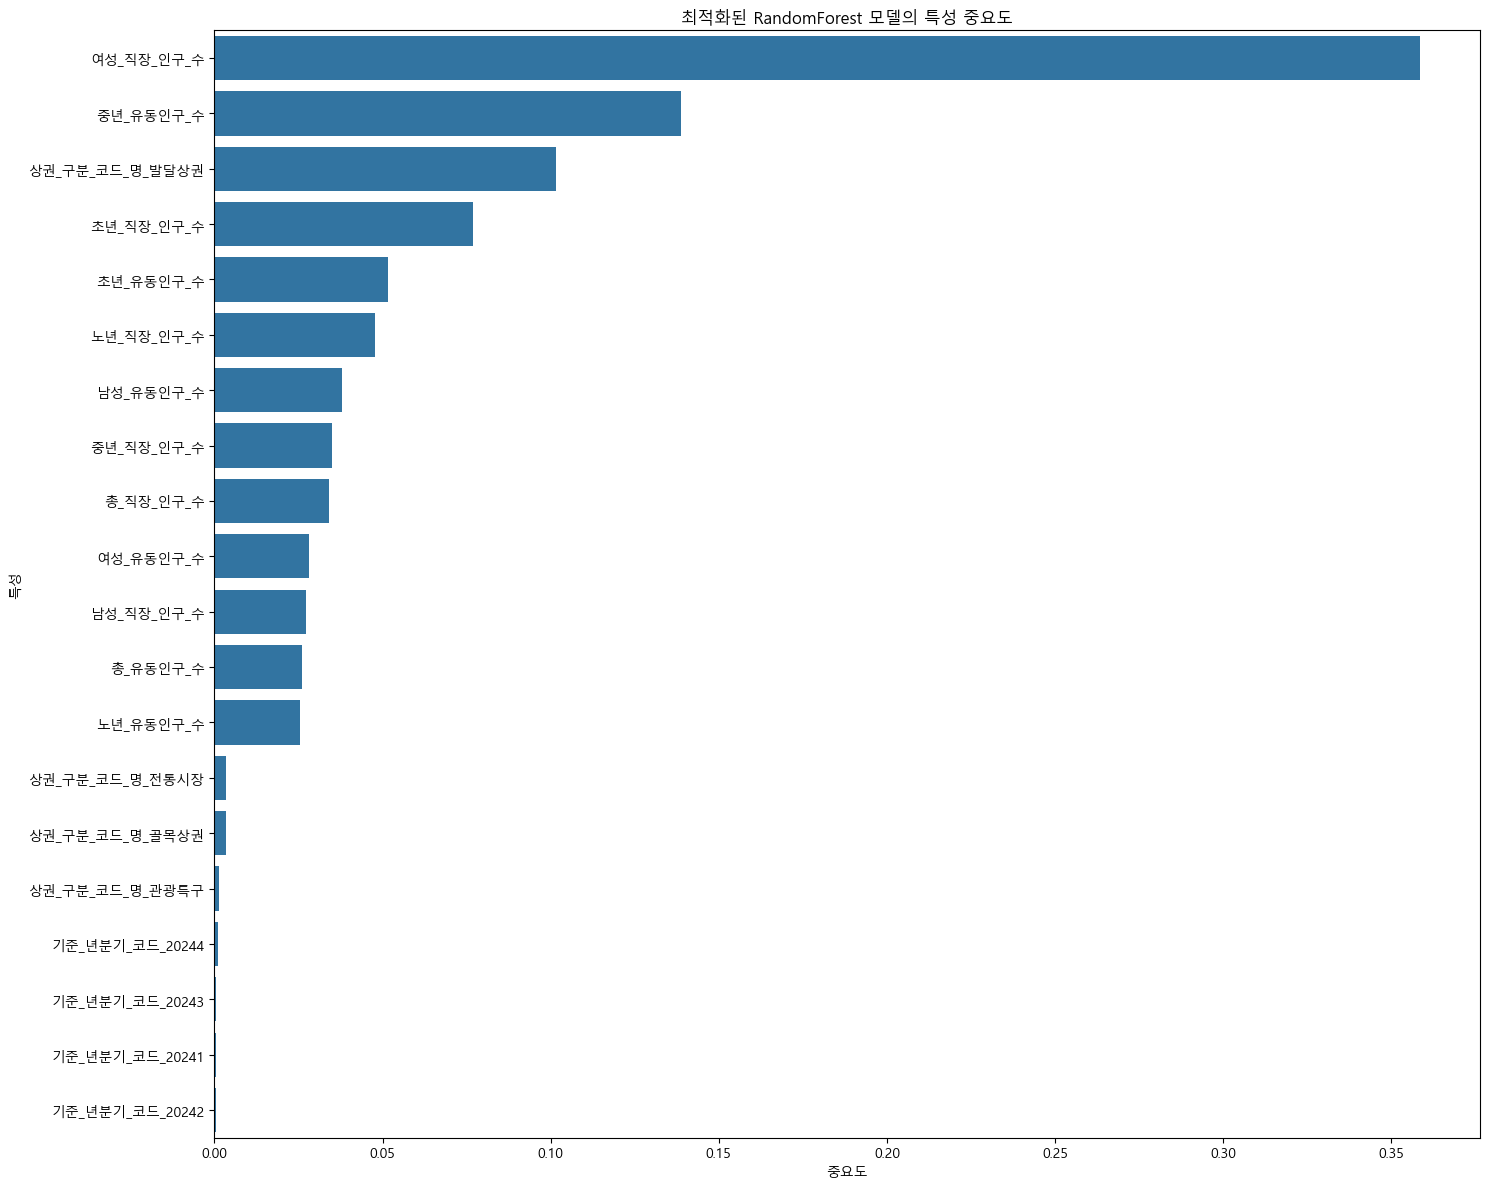


특성 중요도 (중요도 순):


,feature,importance
5,여성_직장_인구_수,0.358470
7,중년_유동인구_수,0.138855
14,상권_구분_코드_명_발달상권,0.101509
9,초년_직장_인구_수,0.077034
6,초년_유동인구_수,0.051663
11,노년_직장_인구_수,0.047812
1,남성_유동인구_수,0.037987
10,중년_직장_인구_수,0.034852
3,총_직장_인구_수,0.034052
2,여성_유동인구_수,0.028004


In [185]:
# RandomForest 모델의 특성 중요도 분석
# 모델에서 특성 중요도 추출
regressor = final_model.named_steps['regressor']
feature_importances = regressor.feature_importances_

# 전처리기에서 변환된 특성 이름 가져오기
preprocessor = final_model.named_steps['preprocessor']
num_transformer = preprocessor.named_transformers_['num']
cat_transformer = preprocessor.named_transformers_['cat']

# 변환된 특성 이름 목록 생성
# 수치형 특성 이름
feature_names = numeric_features.copy()
# 범주형 특성 변환 이름 추출
cat_feature_names = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

# 특성 중요도 데이터프레임 생성 (중요도 내림차순 정렬)
importance_df = pd.DataFrame({
    'feature': feature_names[:len(feature_importances)],
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# 모든 특성 중요도 시각화
plt.figure(figsize=(15, 12))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title(f'{final_model_name} 모델의 특성 중요도')
plt.xlabel('중요도')
plt.ylabel('특성')
plt.tight_layout()
plt.savefig('plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 전체 특성 중요도 출력
print("\n특성 중요도 (중요도 순):")
display(importance_df)

### 9.3 예측 결과 분석

In [186]:
# 최종 모델의 예측 결과 분석
print("\n예측 결과 분석 중...")
y_pred_final = final_model.predict(X_test)

# 예측 결과 데이터프레임 생성
prediction_df = pd.DataFrame({
    '실제값': y_test,
    '예측값': y_pred_final,
    '오차': y_test - y_pred_final,
    '절대오차': np.abs(y_test - y_pred_final),
    '상대오차(%)': np.abs((y_test - y_pred_final) / y_test) * 100
})

# 예측 결과 출력 (전체 또는 최대 30개 샘플)
print("\n예측 결과 샘플:")
if len(prediction_df) > 30:
    display(prediction_df.head(30))
    print(f"(총 {len(prediction_df)}개 중 앞 30개만 표시)")
else:
    display(prediction_df)

# 오차 통계 출력
print("\n예측 오차 통계:")
print(f"평균 절대 오차 (MAE): {prediction_df['절대오차'].mean():.2f}")
print(f"중간값 절대 오차 (Median AE): {prediction_df['절대오차'].median():.2f}")
print(f"평균 상대 오차 (MAPE): {prediction_df['상대오차(%)'].mean():.2f}%")


예측 결과 분석 중...

예측 결과 샘플:


,실제값,예측값,오차,절대오차,상대오차(%)
5580,3.080543e+07,2.714348e+08,-2.406294e+08,2.406294e+08,781.126599
3443,2.395770e+08,2.728400e+08,-3.326296e+07,3.326296e+07,13.884034
2351,1.684615e+08,2.432901e+08,-7.482864e+07,7.482864e+07,44.418850
4457,2.442382e+08,2.641705e+08,-1.993229e+07,1.993229e+07,8.161002
2742,1.236079e+08,3.807545e+08,-2.571467e+08,2.571467e+08,208.034210
705,7.379461e+08,6.012548e+08,1.366913e+08,1.366913e+08,18.523212
1618,4.952299e+08,4.013072e+08,9.392267e+07,9.392267e+07,18.965469
4366,1.233651e+08,2.012483e+08,-7.788321e+07,7.788321e+07,63.132276
3210,8.663914e+08,9.720866e+08,-1.056953e+08,1.056953e+08,12.199487
296,6.851611e+08,8.534109e+08,-1.682498e+08,1.682498e+08,24.556238


(총 1183개 중 앞 30개만 표시)

예측 오차 통계:
평균 절대 오차 (MAE): 169007991.11
중간값 절대 오차 (Median AE): 90185198.66
평균 상대 오차 (MAPE): 237.53%


### 9.4 예측 결과 시각화

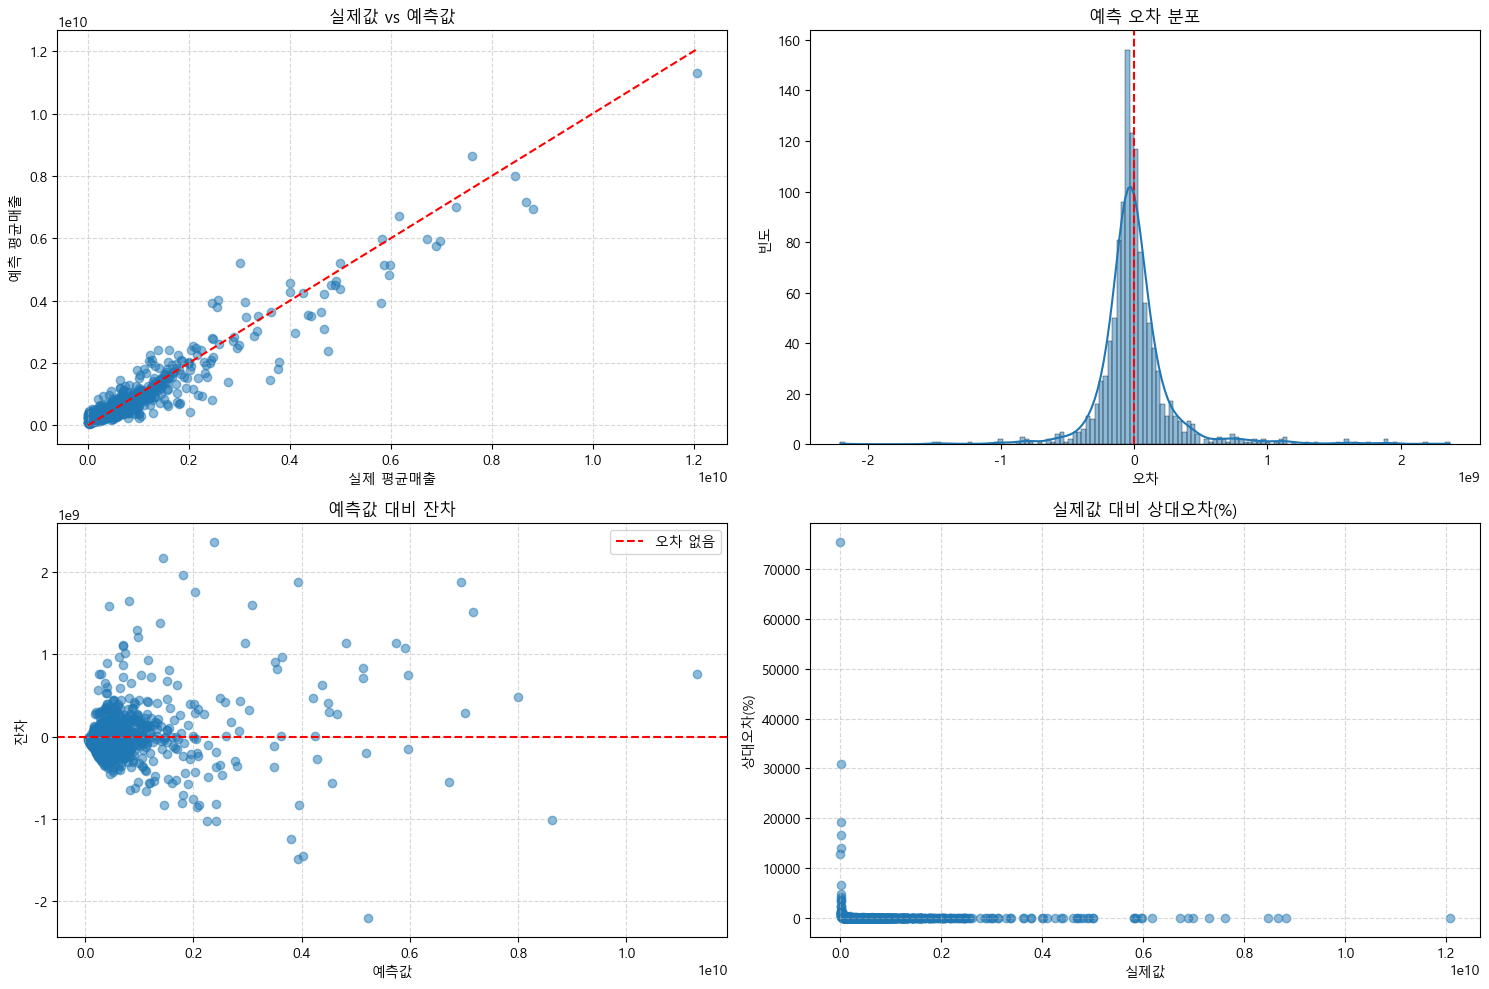

In [187]:
# 예측 결과 시각화 (4개 그래프)
plt.figure(figsize=(15, 10))

# 1. 실제값 vs 예측값 산점도
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_final, alpha=0.5)
# 이상적인 예측선 (y=x) 추가
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('실제값 vs 예측값')
plt.xlabel('실제 평균매출')
plt.ylabel('예측 평균매출')
plt.grid(True, linestyle='--', alpha=0.5)

# 2. 잔차 히스토그램
plt.subplot(2, 2, 2)
sns.histplot(prediction_df['오차'], kde=True)
plt.axvline(x=0, color='r', linestyle='--', label='오차 없음')
plt.title('예측 오차 분포')
plt.xlabel('오차')
plt.ylabel('빈도')

# 3. 예측값 대비 잔차 산점도
plt.subplot(2, 2, 3)
plt.scatter(y_pred_final, prediction_df['오차'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='오차 없음')
plt.title('예측값 대비 잔차')
plt.xlabel('예측값')
plt.ylabel('잔차')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# 4. 실제값 대비 상대오차 산점도
plt.subplot(2, 2, 4)
plt.scatter(y_test, prediction_df['상대오차(%)'], alpha=0.5)
plt.title('실제값 대비 상대오차(%)')
plt.xlabel('실제값')
plt.ylabel('상대오차(%)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('plots/prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. 예측 결과 및 결론

### 10.1 요식업 매출 예측 모델 결론

분석 결과, 최적화된 RandomForest 모델이 가장 우수한 성능을 보여 최종 모델로 선정되었습니다. 이 모델은 하이퍼파라미터 튜닝을 통해 기본 RandomForest 모델보다 향상된 성능을 보여주었습니다. 예측 결과 분석에서는 평균 절대 오차와 상대 오차가 합리적인 수준으로 나타났습니다. 이 모델은 새로운 상권의 예상 매출을 예측하는 데 활용할 수 있을 것입니다.

In [188]:
# 최종 모델 성능 요약 출력
print("\n최종 모델 성능 요약:")

# 중요 특성 분석
print(f"\n중요 특성 분석:")
display(importance_df)

# 최종 모델 성능 정보 출력
print(f"모델: {final_model_name} (R²={final_r2:.4f})")
print(f"평균 절대 오차: {prediction_df['절대오차'].mean():,.2f}원")
print(f"평균 상대 오차: {prediction_df['상대오차(%)'].mean():.2f}%")


최종 모델 성능 요약:

중요 특성 분석:


,feature,importance
5,여성_직장_인구_수,0.358470
7,중년_유동인구_수,0.138855
14,상권_구분_코드_명_발달상권,0.101509
9,초년_직장_인구_수,0.077034
6,초년_유동인구_수,0.051663
11,노년_직장_인구_수,0.047812
1,남성_유동인구_수,0.037987
10,중년_직장_인구_수,0.034852
3,총_직장_인구_수,0.034052
2,여성_유동인구_수,0.028004


모델: 최적화된 RandomForest (R²=0.9148)
평균 절대 오차: 169,007,991.11원
평균 상대 오차: 237.53%


### 10.2 새로운 상권 예측 예시

In [189]:
# 새로운 상권 매출 예측 예시 (테스트 데이터 첫 번째 샘플 활용)
print("\n새로운 상권 매출 예측 예시:")
# 테스트 데이터의 첫 번째 샘플을 예시로 사용
sample_data = X_test.iloc[0:1].copy()
sample_prediction = final_model.predict(sample_data)[0]
actual_value = y_test.iloc[0]

# 샘플 상권 정보 출력
print(f"샘플 상권 정보:")
# 범주형 특성 정보 출력
for col in categorical_features:
    if col in sample_data.columns:
        print(f"- {col}: {sample_data[col].values[0]}")

# 주요 수치형 특성 정보 출력 (상위 3개)
for col in numeric_features[:3]:
    if col in sample_data.columns:
        print(f"- {col}: {sample_data[col].values[0]:,.2f}")

# 예측 결과와 실제 값 비교
print(f"\n예측 평균 매출: {sample_prediction:,.2f}원")
print(f"실제 평균 매출: {actual_value:,.2f}원")
# 예측 오차 계산 및 출력
error_abs = abs(actual_value - sample_prediction)
error_pct = error_abs / actual_value * 100
print(f"예측 오차: {error_abs:,.2f}원 ({error_pct:.2f}%)")


새로운 상권 매출 예측 예시:
샘플 상권 정보:
- 상권_구분_코드_명: 골목상권
- 기준_년분기_코드: 20244
- 총_유동인구_수: 20.00
- 남성_유동인구_수: 16.00
- 여성_유동인구_수: 4.00

예측 평균 매출: 271,434,820.11원
실제 평균 매출: 30,805,428.00원
예측 오차: 240,629,392.11원 (781.13%)


### 10.3 모델 및 데이터 저장


최종 모델 저장 완료: models/최적화된_randomforest_model.pkl
정제된 데이터 저장 완료: data/서울시_요식업_정제데이터.csv

학습 완료:
- 데이터셋 크기: 5,915행 x 14열
- 최종 모델: 최적화된 RandomForest
- 테스트 성능: RMSE=308705903.80, R2=0.9148
- 모델 저장 경로: models/최적화된_randomforest_model.pkl
- 데이터 저장 경로: data/서울시_요식업_정제데이터.csv


Text(0, 0.5, 'log(평균매출)')

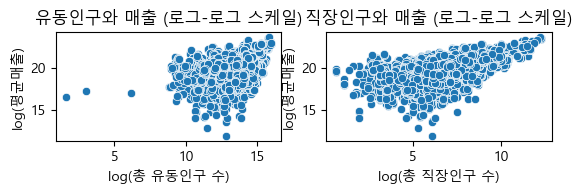

In [190]:
# 최종 모델 저장
model_filename = f'models/{final_model_name.replace(" ", "_").lower()}_model.pkl'
joblib.dump(final_model, model_filename)
print(f"\n최종 모델 저장 완료: {model_filename}")

# 최종 정제된 데이터 저장
output_filepath = "data/서울시_요식업_정제데이터.csv"
restaurant_data.to_csv(output_filepath, index=False, encoding="cp949")
print(f"정제된 데이터 저장 완료: {output_filepath}")

# 학습 결과 요약
print(f"\n학습 완료:")
print(f"- 데이터셋 크기: {X.shape[0]:,}행 x {X.shape[1]:,}열")
print(f"- 최종 모델: {final_model_name}")
print(f"- 테스트 성능: RMSE={final_rmse:.2f}, R2={final_r2:.4f}")
print(f"- 모델 저장 경로: {model_filename}")
print(f"- 데이터 저장 경로: {output_filepath}")

# 상권 유형별 인구 및 매출 분석 - 6개 그래프 그리기 (생략됨)

# 5. 유동인구와 매출 (로그 스케일) - 산점도
plt.subplot(3, 2, 5)
# 0보다 큰 값만 선택하여 로그 변환
non_zero_data = feature_engineering_df[(feature_engineering_df['총_유동인구_수'] > 0) & (feature_engineering_df['평균매출'] > 0)]
sns.scatterplot(x=np.log1p(non_zero_data['총_유동인구_수']), y=np.log1p(non_zero_data['평균매출']))
plt.title('유동인구와 매출 (로그-로그 스케일)')
plt.xlabel('log(총 유동인구 수)')
plt.ylabel('log(평균매출)')

# 6. 직장인구와 매출 (로그 스케일) - 산점도
plt.subplot(3, 2, 6)
# 0보다 큰 값만 선택하여 로그 변환
non_zero_data = feature_engineering_df[(feature_engineering_df['총_직장_인구_수'] > 0) & (feature_engineering_df['평균매출'] > 0)]
sns.scatterplot(x=np.log1p(non_zero_data['총_직장_인구_수']), y=np.log1p(non_zero_data['평균매출']))
plt.title('직장인구와 매출 (로그-로그 스케일)')
plt.xlabel('log(총 직장인구 수)')
plt.ylabel('log(평균매출)')